# Market Assumptions and Reproducibility

## 📋 Black-Scholes Perfect Market Assumptions

This project operates under the **Black-Scholes framework**, which relies on the following perfect market assumptions:

### 1. **Frictionless Markets**
- **No transaction costs**: Trading assets incurs no fees or commissions
- **No taxes**: Capital gains and dividends are not taxed
- **Continuous trading**: Markets are open 24/7, allowing trading at any time
- **Perfect divisibility**: Assets can be divided into arbitrarily small units

### 2. **Market Structure**
- **Competitive markets**: No single trader can influence prices
- **No arbitrage opportunities**: The market is arbitrage-free
- **Short selling allowed**: Investors can short sell any asset without restrictions
- **Unlimited borrowing/lending**: Unlimited access to capital at the risk-free rate

### 3. **Asset Price Dynamics**
The underlying asset follows a **Geometric Brownian Motion (GBM)**:

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

Where:
- $S_t$ = asset price at time $t$
- $\mu$ = drift (expected return)
- $\sigma$ = volatility (constant)
- $W_t$ = standard Brownian motion

### 4. **Constant Parameters**
- **Risk-free rate ($r$)**: Known and constant over time
- **Volatility ($\sigma$)**: Known and constant (no stochastic volatility)
- **No dividends**: The underlying asset pays no dividends during the option's life

### 5. **Informational Efficiency**
- **Perfect information**: All market participants have access to the same information
- **Rational agents**: All investors are rational and aim to maximize expected utility
- **Log-normal distribution**: Asset prices are log-normally distributed

---

## 🔄 Reproducibility: Random Seed Configuration

To ensure **reproducibility** of simulation results across different runs and environments, we set random seeds for all stochastic processes.

### PyTorch Seed Configuration
```python

In [3]:
import torch
torch.manual_seed(0)

# Constants

In [4]:
S0=100
K=100
T=1
Sigma=0.2
R=0.05

# Black-Scholes Analytical Formula

## European Call Option Pricing


### Formula

$$C(S,K,\tau) = S \cdot \Phi(d_1) - K e^{-r\tau} \cdot \Phi(d_2)$$

Where:
- $d_1 = \frac{\ln(S/K) + (r + \frac{\sigma^2}{2})\tau}{\sigma\sqrt{\tau}}$
- $d_2 = d_1 - \sigma\sqrt{\tau}$
- $\Phi(\cdot)$ = Standard normal cumulative distribution function

In [ ]:
import numpy as np
import math
from scipy.stats import norm

def BlackScholesCallPricing(S,K,tau,sigma,r):
    if tau <= 0: 
        return max(0.0, S-K)
    d1 = (math.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return S*norm.cdf(d1) - K*math.exp(-r*tau)*norm.cdf(d2)

In [6]:
BsValue=BlackScholesCallPricing(S0,K,T,Sigma,R)

In [7]:
print(BsValue)

10.450583572185565


# Monte Carlo Simulation

### Discretization Scheme

**Euler-Maruyama approximation** of the GBM:

$$S_{t+\Delta t} = S_t + S_t(r\Delta t + \sigma\Delta W_t)$$

Where $\Delta W_t \sim \mathcal{N}(0, \Delta t)$

### Price Estimation

$$\hat{C} = e^{-rT} \cdot \frac{1}{M} \sum_{i=1}^{M} \max(S_T^{(i)} - K, 0)$$

Where $M$ = `nbSimulation` is the number of Monte Carlo paths.

**Convergence**: Error decreases as $\mathcal{O}(1/\sqrt{M})$ by the Central Limit Theorem.

In [8]:
import torch
import numpy as np

def MonteCarlosEuCallOption(S,K,T,sigma,r,N,nbSimulation):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    S_em = torch.zeros(nbSimulation, N)
    S_em[:, 0] = S
    
    for i in range(N-1):
        S_em[:, i+1] = S_em[:, i] + S_em[:, i]*(r*dt + sigma*dW[:, i])
        
    
    callPayoff=torch.max(S_em[:,-1]-K,torch.zeros(nbSimulation))

    callOptionPrice=math.exp(-r*T)*torch.mean(callPayoff)
    
    return t,S_em,callPayoff,callOptionPrice

In [9]:
N=10000
nbSimulation=10000

In [10]:
t,S_em,callPayoff,callOptionPrice=MonteCarlosEuCallOption(S0,K,T,Sigma,R,N,nbSimulation)

In [11]:
print(callOptionPrice)

tensor(10.1915)


## Plot

Prix estimé du call (Monte Carlo) : 10.1915


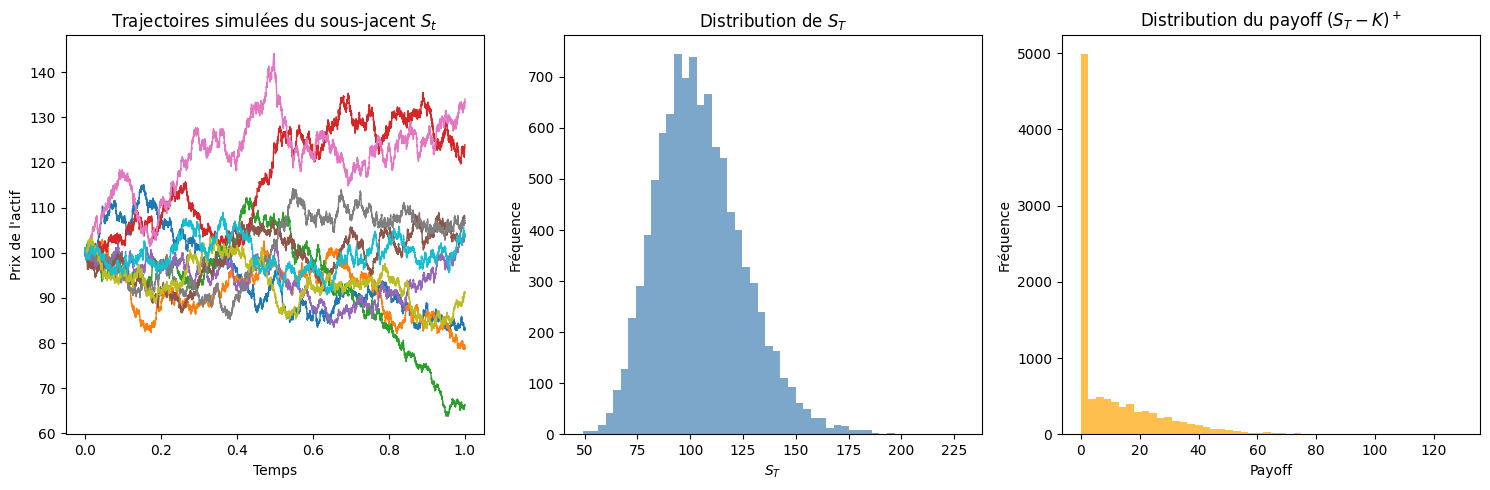

In [12]:
import matplotlib.pyplot as plt

print(f"Prix estimé du call (Monte Carlo) : {callOptionPrice.item():.4f}")

# === Graphiques ===
plt.figure(figsize=(15, 5))

# 1️⃣ Quelques trajectoires simulées
plt.subplot(1, 3, 1)
for i in range(10):
    plt.plot(t, S_em[i].numpy(), lw=1)
plt.title("Trajectoires simulées du sous-jacent $S_t$")
plt.xlabel("Temps")
plt.ylabel("Prix de l'actif")

# 2️⃣ Histogramme du prix final S_T
plt.subplot(1, 3, 2)
plt.hist(S_em[:, -1].numpy(), bins=50, color='steelblue', alpha=0.7)
plt.title("Distribution de $S_T$")
plt.xlabel("$S_T$")
plt.ylabel("Fréquence")

# 3️⃣ Distribution du payoff
plt.subplot(1, 3, 3)
plt.hist(callPayoff.numpy(), bins=50, color='orange', alpha=0.7)
plt.title("Distribution du payoff $(S_T - K)^+$")
plt.xlabel("Payoff")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

# Simulation Results - Visualization

## Trajectory Analysis

The visualizations present three key aspects of the Monte Carlo simulation:

### 1. **Simulated Asset Price Paths**
The first plot displays all trajectories of the asset price simulated using the **Euler-Maruyama scheme**. Each path represents a possible evolution of the stock price under the Geometric Brownian Motion dynamics.

### 2. **Terminal Price Distribution**
The second plot shows the **distribution of asset prices at maturity** ($S_T$). This histogram illustrates the log-normal distribution of terminal prices, consistent with the Black-Scholes framework.

### 3. **Call Option Payoff Distribution**
The final plot presents the **call payoff distribution** at maturity: $\max(S_T - K, 0)$.

**Key Observation**: The payoff exhibits a significantly higher frequency near zero compared to larger values. This behavior is **consistent with Black-Scholes assumptions**, as:
- Many paths finish out-of-the-money ($S_T < K$), resulting in zero payoff
- The payoff is bounded below at zero but unbounded above
- The right tail captures profitable scenarios where $S_T > K$

This asymmetric distribution reflects the fundamental characteristic of call options: **limited downside (premium paid) but unlimited upside potential**.

In [13]:
print(abs(callOptionPrice-BsValue)/BsValue)

tensor(0.0248)


In [34]:
nbSimulations=torch.linspace(100,10000,10)
errors=[]
for n in nbSimulations:
    price=MonteCarlosEuCallOption(S0,K,T,Sigma,R,N,int(n))[3]
    errors.append((price-BsValue)**2)

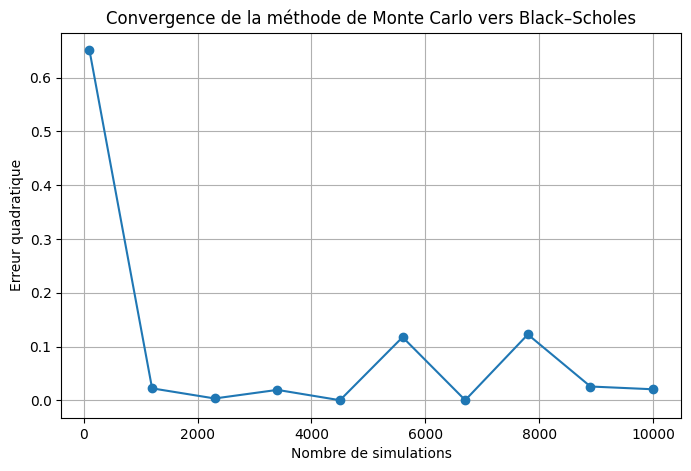

In [35]:
plt.figure(figsize=(8,5))
plt.plot(nbSimulations, errors, marker='o')
plt.xlabel('Nombre de simulations')
plt.ylabel('Erreur quadratique')
plt.title('Convergence de la méthode de Monte Carlo vers Black–Scholes')
plt.grid(True)
plt.show()

##### We observe convergence between the Monte Carlo estimates and the analytical formula.

---

# Digital Option (Cash-or-Nothing)

### Payoff Structure

**Digital (Cash-or-Nothing) Call**:

$$\text{Payoff} = \begin{cases} 
1 & \text{if } S_T > K \\
0 & \text{otherwise}
\end{cases}$$

### Price Estimation

$$\hat{D} = e^{-rT} \cdot \frac{1}{M} \sum_{i=1}^{M} \mathbb{1}_{\{S_T^{(i)} > K\}}$$

Where $\mathbb{1}_{\{\cdot\}}$ is the indicator function.

**Note**: The digital option pays a fixed amount (normalized to 1) if the option finishes in-the-money, regardless of how much. This binary payoff structure makes it fundamentally different from standard call options.

In [16]:
def MonteCarlosDigitalOption(S,K,T,sigma,r,N,nbSimulation):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    S_em = torch.zeros(nbSimulation, N)
    S_em[:, 0] = S
    
    for i in range(N-1):
        S_em[:, i+1] = S_em[:, i] + S_em[:, i]*(r*dt + sigma*dW[:, i])


    S_emMax = torch.max(S_em, dim=1)[0] 

    digitalPayoff=torch.where(S_em[:,-1]>K,torch.ones(nbSimulation),torch.zeros(nbSimulation))

    digitalOptionPrice=math.exp(-r*T)*torch.mean(digitalPayoff)
    
    return t,S_em,S_emMax,digitalPayoff,digitalOptionPrice


In [17]:
K_digital=125
t,S_em,S_emMax,digitalPayoff,digitalOptionPrice=MonteCarlosDigitalOption(S0,K_digital,T,Sigma,R,N,nbSimulation)

In [18]:
print(digitalOptionPrice)

tensor(0.1608)


# Plot

Prix digital (one-touch) : 0.1608


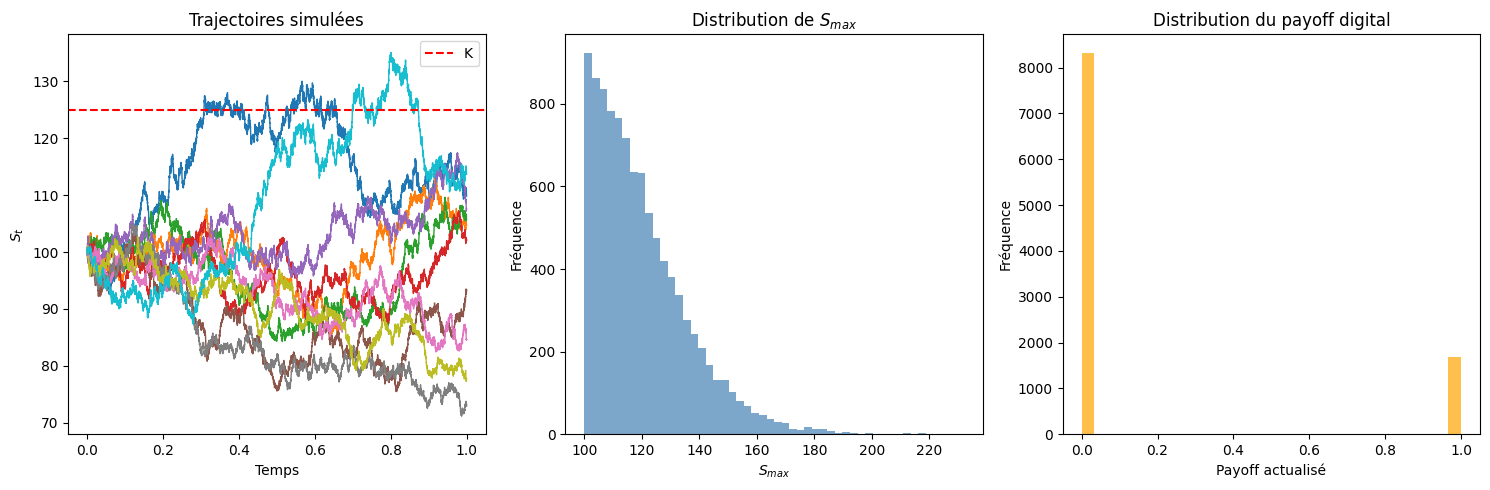

In [19]:
print(f"Prix digital (one-touch) : {digitalOptionPrice.item():.4f}")

# === Graphiques ===
plt.figure(figsize=(15,5))

# 1️⃣ Quelques trajectoires
plt.subplot(1,3,1)
for i in range(10):
    plt.plot(t, S_em[i].numpy(), lw=1)
plt.axhline(K_digital, color='red', ls='--', label='K')
plt.title("Trajectoires simulées")
plt.xlabel("Temps")
plt.ylabel("$S_t$")
plt.legend()

# 2️⃣ Distribution de S_max
plt.subplot(1,3,2)
plt.hist(S_emMax.numpy(), bins=50, color='steelblue', alpha=0.7)
plt.title("Distribution de $S_{max}$")
plt.xlabel("$S_{max}$")
plt.ylabel("Fréquence")

# 3️⃣ Distribution du payoff
plt.subplot(1,3,3)
plt.hist(digitalPayoff.numpy(), bins=30, color='orange', alpha=0.7)
plt.title("Distribution du payoff digital")
plt.xlabel("Payoff actualisé")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()


# 📊 Digital Option Results - Brief Analysis


---

## Key Observations

### 1. **Simulated Trajectories** (Left)
- Multiple GBM paths starting at S₀ = 100
- Red dashed line: Strike K = 125


### 2. **S_max Distribution** (Center)
- **Right-skewed distribution** of maximum prices
- Peak around 100-110 (many paths never exceed initial price significantly)
- Long right tail extends to 200+ (capturing upside potential)

### 3. **Payoff Distribution** (Right)
- **Binary nature clearly visible**:
  - ~**82% receive 0** (barrier not touched)
  - ~**18% receive 1** (barrier touched)
- Matches theoretical digital option structure
- Small discrepancy between distribution (18%) and price (16.08%) due to discounting and Monte Carlo sampling

---

## ✅ Conclusion

The simulation correctly captures digital option characteristics:
- **Path-dependent** barrier monitoring


---

# Lookback Option (Fixed Strike)


### Payoff Structure

**Lookback Call (Fixed Strike)**:

$$\text{Payoff} = \max\left(\max_{0 \leq t \leq T} S_t - K, \, 0\right)$$

Where $\max_{0 \leq t \leq T} S_t$ is the maximum asset price observed over the option's lifetime.

### Price Estimation

$$\hat{L} = e^{-rT} \cdot \frac{1}{M} \sum_{i=1}^{M} \max(S_{\max}^{(i)} - K, 0)$$

**Key Feature**: The holder benefits from the **highest price reached** during the option's life, making this a **path-dependent exotic option**. This provides protection against the risk of not exercising at the optimal moment, but commands a higher premium than standard European calls.

In [20]:
def MonteCarlosLookbackFixedOption(S,K,T,sigma,r,N,nbSimulation):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    S_em = torch.zeros(nbSimulation, N)
    S_em[:, 0] = S
    
    for i in range(N-1):
        S_em[:, i+1] = S_em[:, i] + S_em[:, i]*(r*dt + sigma*dW[:, i])

    S_emMax = torch.max(S_em, dim=1)[0] 

    LookBackPayoff=torch.max(S_emMax-K,torch.zeros(nbSimulation))

    LookBackOptionPrice=math.exp(-r*T)*torch.mean(LookBackPayoff)
        
    
    return t,S_em,S_emMax,LookBackPayoff,LookBackOptionPrice

In [21]:
t,S_em,S_emMax,LookBackPayoff,LookBackOptionPrice=MonteCarlosLookbackFixedOption(S0,K,T,Sigma,R,N,nbSimulation)

In [22]:
print(LookBackOptionPrice)

tensor(18.7842)


# Plot

Prix lookback (Monte Carlo) : 18.7842


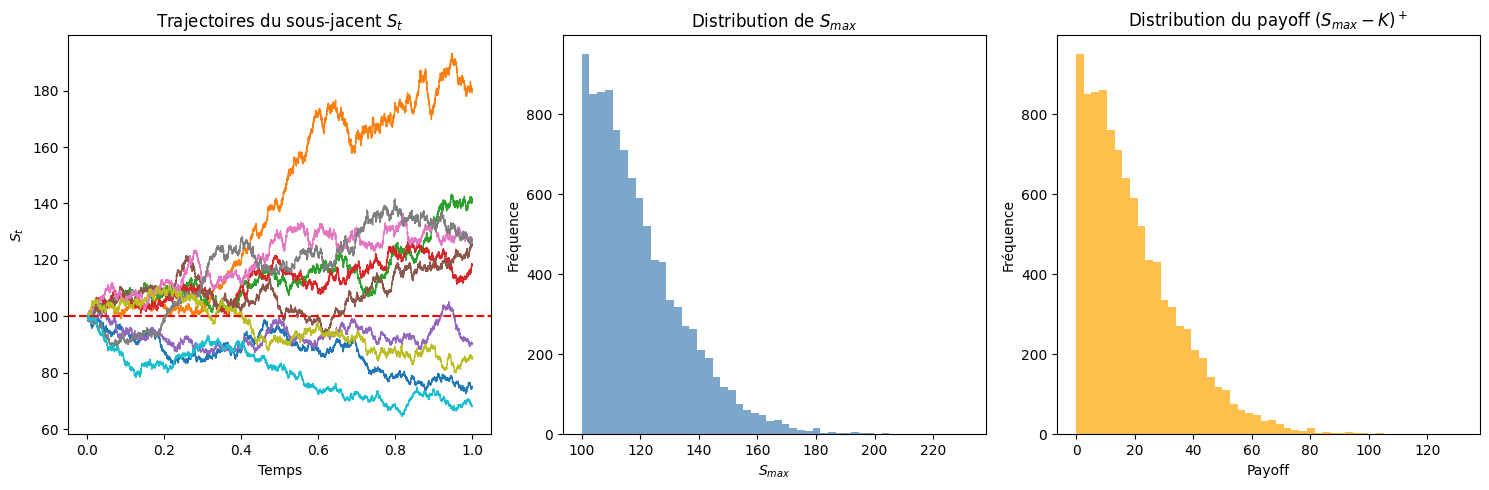

In [23]:
print(f"Prix lookback (Monte Carlo) : {LookBackOptionPrice.item():.4f}")

# === Graphiques ===
plt.figure(figsize=(15,5))

# 1️⃣ Trajectoires du sous-jacent
plt.subplot(1,3,1)
for i in range(10):
    plt.plot(t, S_em[i].numpy(), lw=1)
plt.axhline(K, color='red', ls='--', label='K')
plt.title("Trajectoires du sous-jacent $S_t$")
plt.xlabel("Temps")
plt.ylabel("$S_t$")

# 2️⃣ Distribution du maximum S_max
plt.subplot(1,3,2)
plt.hist(S_emMax.numpy(), bins=50, color='steelblue', alpha=0.7)
plt.title("Distribution de $S_{max}$")
plt.xlabel("$S_{max}$")
plt.ylabel("Fréquence")

# 3️⃣ Distribution du payoff
plt.subplot(1,3,3)
plt.hist(LookBackPayoff.numpy(), bins=50, color='orange', alpha=0.7)
plt.title("Distribution du payoff $(S_{max} - K)^+$")
plt.xlabel("Payoff")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

# 📊 Lookback Option Results

**Key Observation**: The S_max distribution is identical to the digital option case (same underlying paths). The payoff distribution correctly represents a **translation of S_max by the strike K**, with truncation at zero via max(S_max - K, 0). This transformation is **theoretically consistent** with the lookback payoff structure.

---

# Lookback Option - Analytical Formula

### Analytical Formula

$$L(S_0, \tau) = S_0 \Phi(a_1) - S_0 e^{-r\tau} \Phi(a_2) - \frac{S_0 \sigma^2}{2r}\Phi(-a_1) + \frac{S_0 \sigma^2}{2r}e^{-r\tau}\Phi(-a_3)$$

Where:
- $a_1 = \frac{(r + \frac{\sigma^2}{2})\tau}{\sigma\sqrt{\tau}}$
- $a_2 = a_1 - \sigma\sqrt{\tau}$
- $a_3 = a_1 - \frac{2r\sqrt{\tau}}{\sigma}$

**Note**: This closed-form solution serves as the benchmark for validating Monte Carlo simulations of lookback options. The formula assumes continuous monitoring of the asset price and is valid for **floating strike** lookback calls.

In [24]:
def BlackScholesLookbackPricing(S0,tau,sigma,r):
    a1=(r+(sigma**2)/2)*tau/(sigma*math.sqrt(tau))
    a2=a1-sigma*math.sqrt(tau)
    a3=a1-(2*r*math.sqrt(tau))/sigma
    part1=S0*norm.cdf(a1)
    part2=S0*math.exp(-r*tau)*norm.cdf(a2)
    part3=(S0*sigma**2)/(2*r)*norm.cdf(-a1)
    part4=(S0*sigma**2)/(2*r)*math.exp(-r*tau)*norm.cdf(-a3)
    return part1-part2-part3+part4

In [25]:
bsLookbackPrice=BlackScholesLookbackPricing(S0,T,Sigma,R)

In [26]:
print(bsLookbackPrice)

17.216802237360866


# Lookback Option (Floating Strike)

### Payoff Structure

**Lookback Call (Floating Strike)**:

$$\text{Payoff} = S_T - \min_{0 \leq t \leq T} S_t$$

Where $\min_{0 \leq t \leq T} S_t$ is the minimum asset price observed over the option's lifetime.

### Price Estimation

$$\hat{L}_{\text{float}} = e^{-rT} \cdot \frac{1}{M} \sum_{i=1}^{M} \max(S_T^{(i)} - S_{\min}^{(i)}, 0)$$

**Key Difference**: Unlike the fixed strike version, the floating strike lookback allows the holder to **"buy at the lowest price"** observed during the option's life and sell at maturity. The payoff is always non-negative since $S_T \geq S_{\min}$ by definition, making this option inherently valuable.

**Comparison**:
- **Fixed Strike**: Payoff based on maximum price reached
- **Floating Strike**: Payoff based on difference between terminal and minimum price

In [27]:
def MonteCarlosLookbackFloatingOption(S,T,sigma,r,N,nbSimulation):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    S_em = torch.zeros(nbSimulation, N)
    S_em[:, 0] = S
    
    for i in range(N-1):
        S_em[:, i+1] = S_em[:, i] + S_em[:, i]*(r*dt + sigma*dW[:, i])

    S_emMin = torch.min(S_em, dim=1)[0] 

    LookBackPayoff=torch.max(S_em[:,-1]-S_emMin,torch.zeros(nbSimulation))

    LookBackOptionPrice=math.exp(-r*T)*torch.mean(LookBackPayoff)
        
    
    return t,S_em,S_emMin,LookBackPayoff,LookBackOptionPrice

In [28]:
t,S_em,S_emMin,LookBackPayoff,LookBackOptionPrice=MonteCarlosLookbackFloatingOption(S0,T,Sigma,R,N,nbSimulation)

In [29]:
print(LookBackOptionPrice)

tensor(17.2103)


# Plot

Prix de l'option lookback flottante : 17.2103


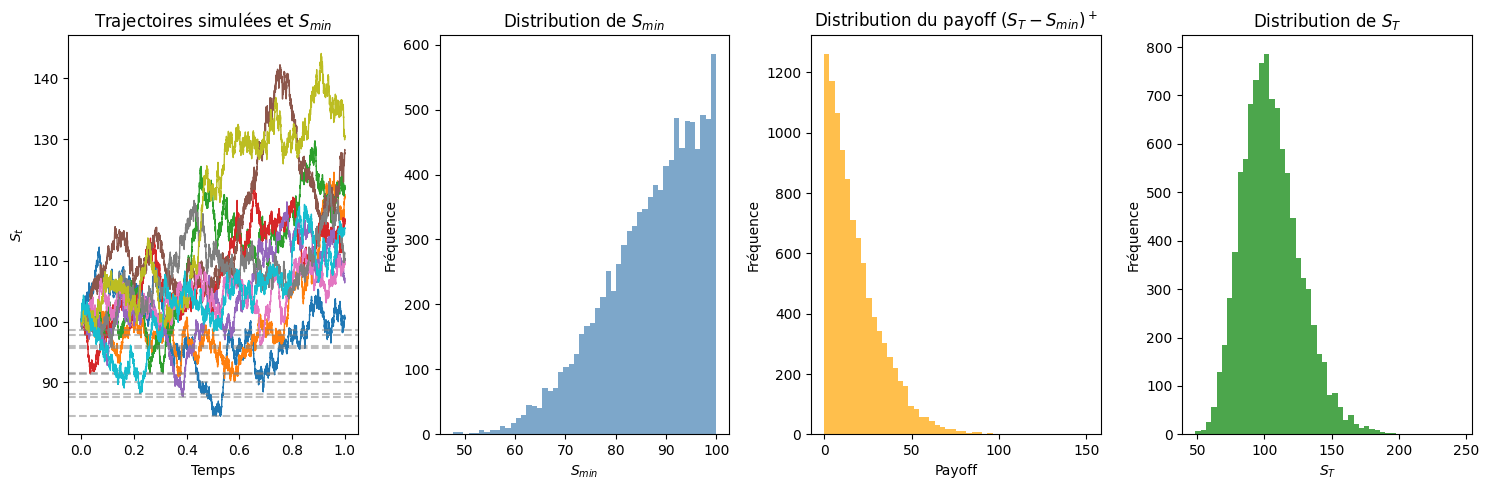

In [30]:
print(f"Prix de l'option lookback flottante : {LookBackOptionPrice.item():.4f}")

# === Graphiques ===
plt.figure(figsize=(15,5))

# 1️⃣ Quelques trajectoires et leurs minimums
plt.subplot(1,4,1)
for i in range(10):
    plt.plot(t, S_em[i].numpy(), lw=1)
    plt.axhline(S_emMin[i].item(), color='gray', ls='--', alpha=0.5)
plt.title("Trajectoires simulées et $S_{min}$")
plt.xlabel("Temps")
plt.ylabel("$S_t$")

# 2️⃣ Distribution des minimums
plt.subplot(1,4,2)
plt.hist(S_emMin.numpy(), bins=50, color='steelblue', alpha=0.7)
plt.title("Distribution de $S_{min}$")
plt.xlabel("$S_{min}$")
plt.ylabel("Fréquence")

# 3️⃣ Distribution du payoff
plt.subplot(1,4,3)
plt.hist(LookBackPayoff.numpy(), bins=50, color='orange', alpha=0.7)
plt.title("Distribution du payoff $(S_T - S_{min})^+$")
plt.xlabel("Payoff")
plt.ylabel("Fréquence")

# 4️⃣ Distribution de S_T
plt.subplot(1,4,4)
plt.hist(S_em[:,-1].numpy(), bins=50, color='green', alpha=0.7)
plt.title("Distribution de $S_T$")
plt.xlabel("$S_T$")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

# 📊 Floating Lookback Option Results


**Key Observation**: The S_min distribution shows left-skewed concentration around 50-100, capturing downside paths. The payoff distribution (S_T - S_min)⁺ exhibits **strictly positive values** since S_T ≥ S_min by definition, explaining the higher premium. The terminal price S_T distribution (green, right panel) follows the expected **log-normal shape**, centered around 105, consistent with GBM dynamics under risk-neutral measure.

In [46]:
nbSimulations=np.linspace(100,10000,10)
errors=[]
for n in nbSimulations:
    price=MonteCarlosLookbackFloatingOption(S0,T,Sigma,R,N,int(n))[4]
    errors.append((price-bsLookbackPrice)**2)

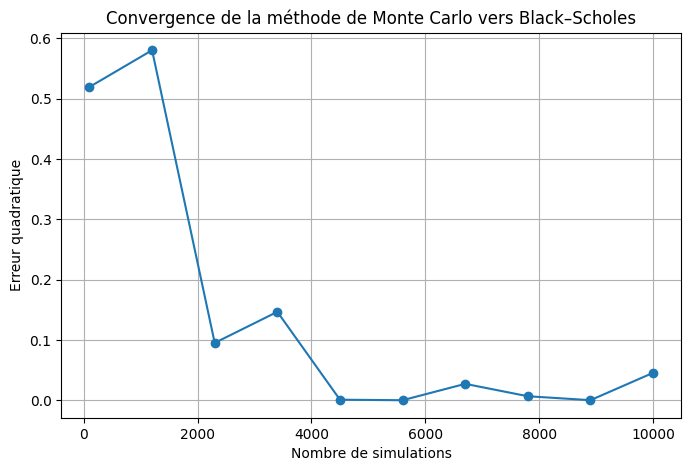

In [47]:
plt.figure(figsize=(8,5))
plt.plot(nbSimulations, errors, marker='o')
plt.xlabel('Nombre de simulations')
plt.ylabel('Erreur quadratique')
plt.title('Convergence de la méthode de Monte Carlo vers Black–Scholes')
plt.grid(True)
plt.show()

##### We observe convergence between the Monte Carlo estimates and the analytical formula.

---

# Asian Option (Arithmetic Average)

### Payoff Structure

**Asian Call (Arithmetic Average)**:

$$\text{Payoff} = \max\left(\frac{1}{N}\sum_{i=0}^{N-1} S_{t_i} - K, \, 0\right)$$

Where the payoff depends on the **arithmetic average** of the asset price over the option's lifetime.

### Price Estimation

$$\hat{A} = e^{-rT} \cdot \frac{1}{M} \sum_{j=1}^{M} \max(\bar{S}^{(j)} - K, 0)$$

Where $\bar{S}^{(j)} = \frac{1}{N}\sum_{i=0}^{N-1} S_{t_i}^{(j)}$ is the average price along path $j$.

**Key Features**:
- **Path-dependent**: Payoff depends on the entire price trajectory, not just terminal value
- **Lower volatility**: Averaging reduces the impact of extreme price movements
- **Cheaper premium**: Typically less expensive than standard European calls due to reduced volatility
- **No closed-form solution**: Monte Carlo or approximation methods required for pricing

**Use case**: Popular in commodity markets and FX options where averaging mitigates manipulation risk.

In [32]:
def MonteCarlosAsianOption(S,K,T,sigma,r,N,nbSimulation):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    S_em = torch.zeros(nbSimulation, N)
    S_em[:, 0] = S
    
    for i in range(N-1):
        S_em[:, i+1] = S_em[:, i] + S_em[:, i]*(r*dt + sigma*dW[:, i])

    S_emAvg = torch.mean(S_em,1) 

    AsianPayoff=torch.max(S_emAvg-K,torch.zeros(nbSimulation))

    AsianOptionPrice=math.exp(-r*T)*torch.mean(AsianPayoff)
        
    
    return t,S_em,S_emAvg,AsianPayoff,AsianOptionPrice

In [33]:
t,S_em,S_emAvg,AsianPayoff,AsianOptionPrice=MonteCarlosAsianOption(S0,K,T,Sigma,R,N,nbSimulation)

In [34]:
print(AsianOptionPrice)

tensor(5.7597)


# Plot

Prix de l'option asiatique : 5.7597


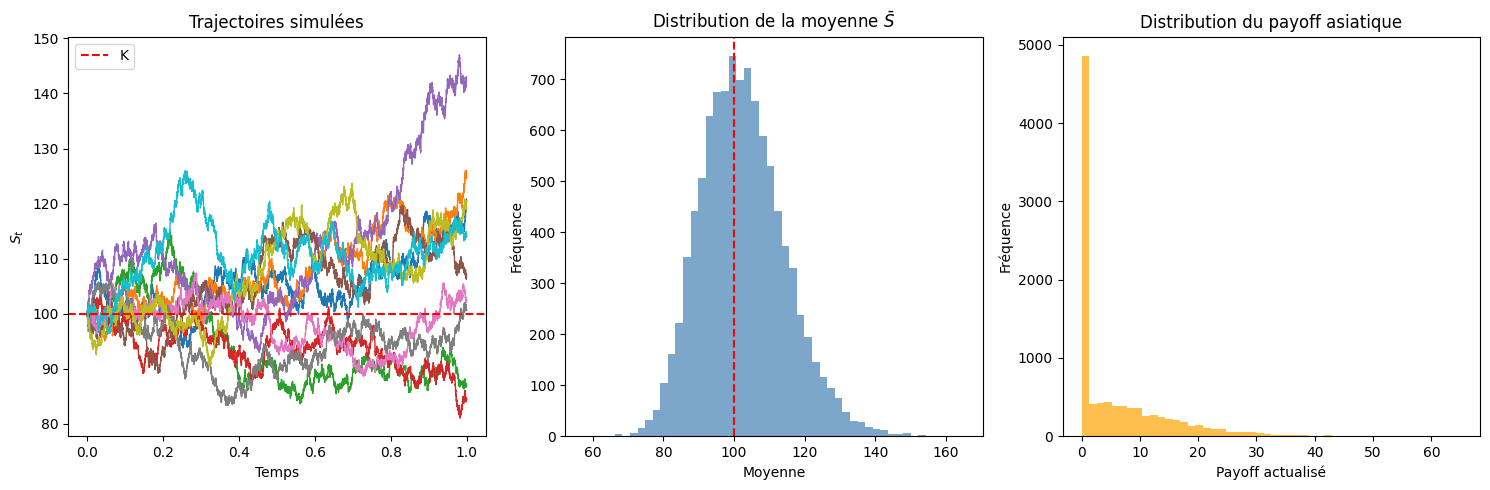

In [35]:
print(f"Prix de l'option asiatique : {AsianOptionPrice.item():.4f}")

# === Graphiques ===
plt.figure(figsize=(15,5))

# 1️⃣ Quelques trajectoires
plt.subplot(1,3,1)
for i in range(10):
    plt.plot(t, S_em[i].numpy(), lw=1)
plt.axhline(K, color='red', ls='--', label='K')
plt.title("Trajectoires simulées")
plt.xlabel("Temps")
plt.ylabel("$S_t$")
plt.legend()

# 2️⃣ Distribution des moyennes
plt.subplot(1,3,2)
plt.hist(S_emAvg.numpy(), bins=50, color='steelblue', alpha=0.7)
plt.axvline(K, color='red', ls='--', label='K')
plt.title("Distribution de la moyenne $\\bar{S}$")
plt.xlabel("Moyenne")
plt.ylabel("Fréquence")

# 3️⃣ Distribution du payoff
plt.subplot(1,3,3)
plt.hist(AsianPayoff.numpy(), bins=50, color='orange', alpha=0.7)
plt.title("Distribution du payoff asiatique")
plt.xlabel("Payoff actualisé")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

# 📊 Asian Option Results


**Key Observation**: The average price distribution (center) is **highly concentrated around S₀ = 100** with reduced variance compared to terminal prices, demonstrating the variance-dampening effect of arithmetic averaging. The payoff distribution shows **~50% zero payoffs** (out-of-the-money) with a smooth right tail for profitable scenarios. This reduced volatility explains the **lower premium** relative to standard options, making Asian options attractive for hedging when dampened sensitivity is desired.

---

# Barrier Option - Analytical Formula

## Up-and-In Call Option

**Up-and-In Call**: A knock-in barrier option that becomes active only if the asset price reaches or exceeds the barrier level $H$ during the option's life.

### Payoff Structure

$$\text{Payoff} = \begin{cases} 
\max(S_T - K, 0) & \text{if } \max_{0 \leq t \leq T} S_t \geq H \\
0 & \text{otherwise}
\end{cases}$$

### Analytical Formula

$$C_{\text{UI}} = p_1 - p_2 - p_3 + p_4$$

Where:
- $\lambda = \frac{r - q + \frac{\sigma^2}{2}}{\sigma^2}$ (adjusted drift parameter)
- $x_1 = \frac{\ln(S_0/H)}{\sigma\sqrt{T}} + \lambda\sigma\sqrt{T}$
- $y_1 = \frac{\ln(H/S_0)}{\sigma\sqrt{T}} + \lambda\sigma\sqrt{T}$
- $y = \frac{\ln(H^2/(S_0 K))}{\sigma\sqrt{T}} + \lambda\sigma\sqrt{T}$

And:
- $p_1 = S_0 \Phi(x_1) e^{-qT}$
- $p_2 = K e^{-rT} \Phi(x_1 - \sigma\sqrt{T})$
- $p_3 = S_0 e^{-qT} \left(\frac{H}{S_0}\right)^{2\lambda} [\Phi(-y) - \Phi(-y_1)]$
- $p_4 = K e^{-rT} \left(\frac{H}{S_0}\right)^{2\lambda-2} [\Phi(-y + \sigma\sqrt{T}) - \Phi(-y_1 + \sigma\sqrt{T})]$

**Note**: This closed-form solution accounts for the probability of the barrier being hit and the conditional payoff structure. The formula includes reflection terms to capture the barrier crossing dynamics.

**Constraint**: For an up-and-in call, we require $H > S_0$ (barrier above initial price).

In [ ]:
def BlackScholesBarrierUIPricing(S0,K,H,r,q,sigma,T):
    lbd=(r-q+(sigma**2)/2)/sigma**2
    y=math.log(H**2/(S0*K))/(sigma*math.sqrt(T))+lbd*sigma*math.sqrt(T)
    x1=math.log(S0/H)/(sigma*math.sqrt(T))+lbd*sigma*math.sqrt(T)
    y1=math.log(H/S0)/(sigma*math.sqrt(T))+lbd*sigma*math.sqrt(T)
    p1=S0*norm.cdf(x1)*math.exp(-q*T)
    p2=K*math.exp(-r*T)*norm.cdf(x1-sigma*math.sqrt(T))
    p3=S0*math.exp(-q*T)*(H/S0)**(2*lbd)*(norm.cdf(-y)-norm.cdf(-y1))
    p4=K*math.exp(-r*T)*(H/S0)**(2*lbd-2)*(norm.cdf(-y+sigma*math.sqrt(T))-norm.cdf(-y1+sigma*math.sqrt(T)))
    return p1-p2-p3+p4

In [81]:
H=120
BsBarrierUI=BlackScholesBarrierUIPricing(S0,K,H,R,0,Sigma,T)

In [82]:
print(BsBarrierUI)

-34.31605452891647


# Barrier Option - Monte Carlo Simulation

### Payoff Logic

**Two-step evaluation**:

1. **Standard call payoff**: $\text{Call} = \max(S_T - K, 0)$

2. **Barrier activation**: 
$$\text{Payoff} = \begin{cases} 
\text{Call} & \text{if } \max_{0 \leq t \leq T} S_t > H \\
0 & \text{otherwise}
\end{cases}$$

### Price Estimation

$$\hat{C}_{\text{UI}} = e^{-rT} \cdot \frac{1}{M} \sum_{i=1}^{M} \mathbb{1}_{\{S_{\max}^{(i)} > H\}} \cdot \max(S_T^{(i)} - K, 0)$$

Where $\mathbb{1}_{\{\cdot\}}$ is the indicator function for barrier crossing.

**Key Feature**: The option only "knocks in" (becomes active) if the barrier is breached. This path-dependent structure makes the option cheaper than a standard European call, as there's a probability it never activates.

**Monitoring**: This implementation uses **discrete monitoring** at each time step. For continuous monitoring (as in the analytical formula), increase $N$ to reduce discretization bias.

In [49]:
def MonteCarlosBarrierUIOption(S,K,H,r,sigma,T,N,nbSimulation):
    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    S_em = torch.zeros(nbSimulation, N)
    S_em[:, 0] = S
    
    for i in range(N-1):
        S_em[:, i+1] = S_em[:, i] + S_em[:, i]*(r*dt + sigma*dW[:, i])

    S_emMax = torch.max(S_em, dim=1)[0] 

    CallPayoff=torch.max(S_em[:,-1]-K,torch.zeros(nbSimulation))
        
    BarrierPayoff=torch.where(S_emMax>H,CallPayoff,torch.zeros_like(S_emMax))

    BarrierPrice=math.exp(-r*T)*BarrierPayoff.mean()

    return t,S_em,S_emMax,BarrierPayoff,BarrierPrice

In [53]:
t,S_em,S_emMax,BarrierPayoff,BarrierPriceUI=MonteCarlosBarrierUIOption(S0,K,H,R,Sigma,T,N,nbSimulation)

In [54]:
print(BarrierPriceUI)

tensor(9.1696)


# Plot

Prix de l'option barrière up-and-in : 9.1696


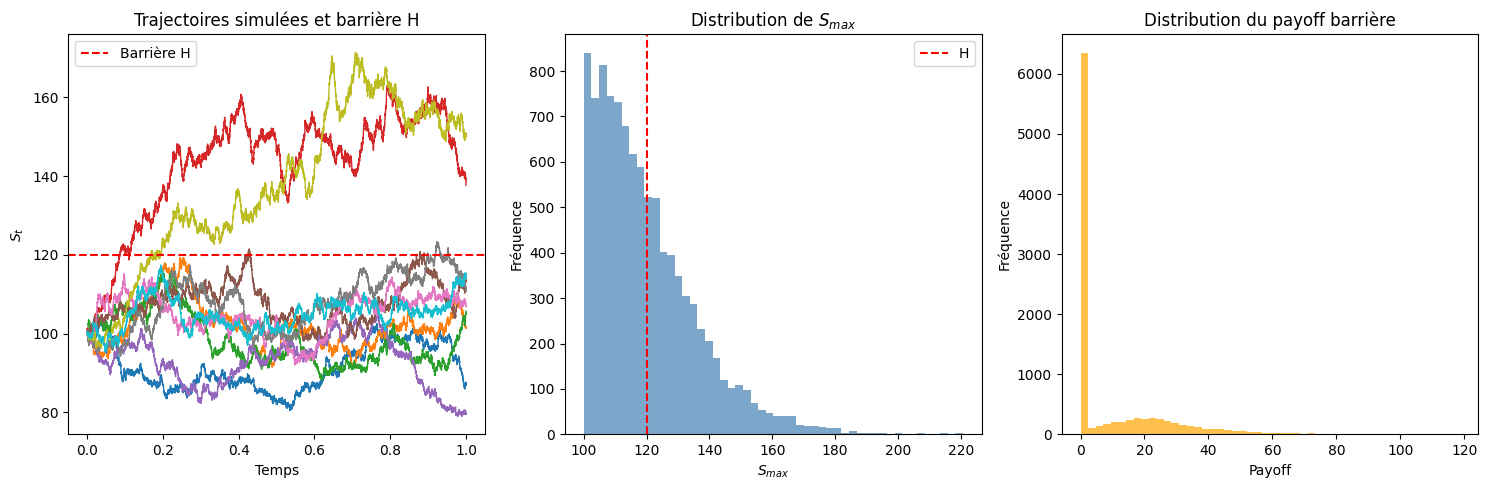

In [55]:
print(f"Prix de l'option barrière up-and-in : {BarrierPriceUI.item():.4f}")

# === Graphiques ===
plt.figure(figsize=(15,5))

# 1️⃣ Trajectoires (certaines franchissent H)
plt.subplot(1,3,1)
for i in range(10):
    plt.plot(t, S_em[i].numpy(), lw=1)
plt.axhline(H, color='red', ls='--', label='Barrière H')
plt.title("Trajectoires simulées et barrière H")
plt.xlabel("Temps")
plt.ylabel("$S_t$")
plt.legend()

# 2️⃣ Distribution du maximum S_max
plt.subplot(1,3,2)
plt.hist(S_emMax.numpy(), bins=50, color='steelblue', alpha=0.7)
plt.axvline(H, color='red', ls='--', label='H')
plt.title("Distribution de $S_{max}$")
plt.xlabel("$S_{max}$")
plt.ylabel("Fréquence")
plt.legend()

# 3️⃣ Distribution du payoff barrière
plt.subplot(1,3,3)
plt.hist(BarrierPayoff.numpy(), bins=50, color='orange', alpha=0.7)
plt.title("Distribution du payoff barrière")
plt.xlabel("Payoff")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

# 📊 Up-and-In Barrier Option Results

**Key Observation**: The trajectories show clear **barrier activation** at H = 120 (red dashed line), with only paths breaching H (red, yellow) receiving payoffs. The S_max distribution confirms **significant mass below H**, explaining the reduced price. The payoff distribution exhibits **~60% zero payoffs** (barrier never touched) with a long right tail for activated scenarios. This knock-in feature reduces premium compared to vanilla calls, making barrier options cost-effective for directional views with specific barrier expectations.

In [56]:
print(abs(BsBarrierUI-BarrierPriceUI)/BsBarrierUI)

tensor(0.0113)


In [57]:
nbSimulations=np.linspace(100,10000,10)
errors=[]
for n in nbSimulations:
    price=MonteCarlosBarrierUIOption(S0,K,H,R,Sigma,T,N,int(n))[4]
    errors.append((price-BsBarrierUI)**2)

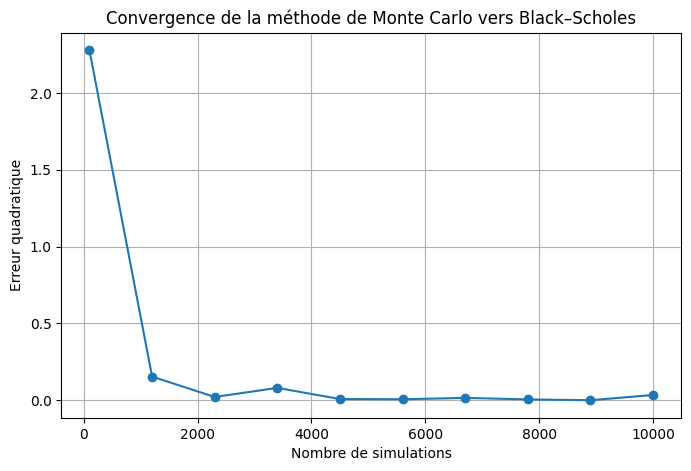

In [58]:
plt.figure(figsize=(8,5))
plt.plot(nbSimulations, errors, marker='o')
plt.xlabel('Nombre de simulations')
plt.ylabel('Erreur quadratique')
plt.title('Convergence de la méthode de Monte Carlo vers Black–Scholes')
plt.grid(True)
plt.show()

##### We observe convergence between the Monte Carlo estimates and the analytical formula.

---

# Barrier Option - Analytical Formula

## Down-and-Out Call Option

**Down-and-Out Call**: A knock-out barrier option that becomes worthless if the asset price falls to or below the barrier level $H$ during the option's life.

### Payoff Structure

$$\text{Payoff} = \begin{cases} 
\max(S_T - K, 0) & \text{if } \min_{0 \leq t \leq T} S_t > H \\
0 & \text{otherwise}
\end{cases}$$

### Analytical Formula

$$C_{\text{DO}} = p_1 - p_2 - p_3 + p_4$$

Where:
- $\lambda = \frac{r - q + \frac{\sigma^2}{2}}{\sigma^2}$ (adjusted drift parameter)
- $x_1 = \frac{\ln(S_0/H)}{\sigma\sqrt{T}} + \lambda\sigma\sqrt{T}$
- $y_1 = \frac{\ln(H/S_0)}{\sigma\sqrt{T}} + \lambda\sigma\sqrt{T}$

And:
- $p_1 = S_0 \Phi(x_1) e^{-qT}$
- $p_2 = K e^{-rT} \Phi(x_1 - \sigma\sqrt{T})$
- $p_3 = S_0 e^{-qT} \left(\frac{H}{S_0}\right)^{2\lambda} \Phi(y_1)$
- $p_4 = K e^{-rT} \left(\frac{H}{S_0}\right)^{2\lambda-2} \Phi(y_1 - \sigma\sqrt{T})$

**Note**: This closed-form solution accounts for the probability of the barrier **not** being hit. The option remains alive only if the asset price stays above the barrier throughout the option's life.

**Constraint**: For a down-and-out call, we require $H < S_0$ (barrier below initial price).

**Relationship**: $C_{\text{Standard}} = C_{\text{DO}} + C_{\text{DI}}$ (down-and-out + down-and-in = standard call)

In [3]:
def BlackScholesBarrierDOPricing(S0,K,H,r,q,sigma,T):
    mu = (r - q - 0.5 * sigma**2) / sigma**2
    lambd = math.sqrt(T)
    
    d1 = (math.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * lambd)
    d2 = d1 - sigma * lambd
    d3 = (math.log(H**2 / (S0 * K)) + (r - q + 0.5 * sigma**2) * T) / (sigma * lambd)
    d4 = d3 - sigma * lambd

    term1 = S0 * math.exp(-q*T) * (norm.cdf(d1) - (H/S0)**(2*mu) * norm.cdf(d3))
    term2 = K * math.exp(-r*T) * (norm.cdf(d2) - (H/S0)**(2*mu - 2) * norm.cdf(d4))
    
    return term1 - term2

In [2]:
H=80
BsBarrierDO=BlackScholesBarrierDOPricing(S0,K,H,R,0,Sigma,T)

NameError: name 'S0' is not defined

In [85]:
print(BsBarrierDO)

10.295523617496485


# Barrier Option - Monte Carlo Simulation

## Down-and-Out Call Option

### Payoff Logic

**Two-step evaluation**:

1. **Standard call payoff**: $\text{Call} = \max(S_T - K, 0)$

2. **Barrier knock-out condition**: 
$$\text{Payoff} = \begin{cases} 
\text{Call} & \text{if } \min_{0 \leq t \leq T} S_t > H \\
0 & \text{otherwise (knocked out)}
\end{cases}$$

### Price Estimation

$$\hat{C}_{\text{DO}} = e^{-rT} \cdot \frac{1}{M} \sum_{i=1}^{M} \mathbb{1}_{\{S_{\min}^{(i)} > H\}} \cdot \max(S_T^{(i)} - K, 0)$$

Where $\mathbb{1}_{\{\cdot\}}$ is the indicator function checking that the barrier was **never touched**.

**Key Feature**: The option "knocks out" (becomes worthless) if the barrier is breached from above. This makes the option **cheaper** than a standard European call, as paths that touch the barrier receive zero payoff regardless of the terminal value.

**Monitoring**: This implementation uses **discrete monitoring** at each time step. The probability of knock-out is slightly underestimated compared to continuous monitoring (analytical formula), since the price could theoretically breach the barrier between observation points.

**Risk**: Investors face the risk that a temporary price drop eliminates the option entirely, even if the price recovers later.

In [86]:
def MonteCarlosBarrierDOOption(S,K,H,r,sigma,T,N,nbSimulation):
    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    S_em = torch.zeros(nbSimulation, N)
    S_em[:, 0] = S
    
    for i in range(N-1):
        S_em[:, i+1] = S_em[:, i] + S_em[:, i]*(r*dt + sigma*dW[:, i])

    S_emMin = torch.min(S_em, dim=1)[0] 

    CallPayoff=torch.max(S_em[:,-1]-K,torch.zeros(nbSimulation))
        
    BarrierPayoff=torch.where(S_emMin<H,torch.zeros_like(S_emMin),CallPayoff)

    BarrierPrice=math.exp(-r*T)*BarrierPayoff.mean()

    return t,S_em,S_emMin,BarrierPayoff,BarrierPrice

In [87]:
t,S_em,S_emMin,BarrierPayoff,BarrierPriceDO=MonteCarlosBarrierDOOption(S0,K,H,R,Sigma,T,N,nbSimulation)

In [88]:
print(BarrierPriceDO)

tensor(10.6393)


# Plot

Prix de l'option barrière down-and-out : 10.6393


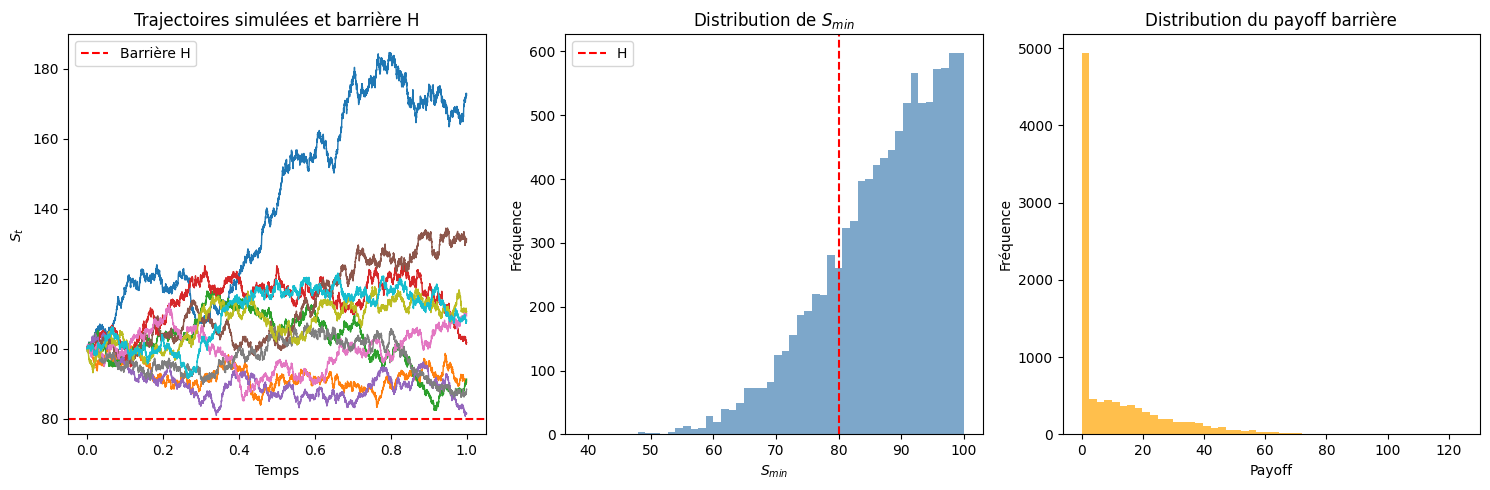

In [89]:
# === Résultats ===
print(f"Prix de l'option barrière down-and-out : {BarrierPriceDO.item():.4f}")

# === Graphiques ===
plt.figure(figsize=(15,5))

# 1️⃣ Trajectoires (certaines franchissent H)
plt.subplot(1,3,1)
for i in range(10):
    plt.plot(t, S_em[i].numpy(), lw=1)
plt.axhline(H, color='red', ls='--', label='Barrière H')
plt.title("Trajectoires simulées et barrière H")
plt.xlabel("Temps")
plt.ylabel("$S_t$")
plt.legend()

# 2️⃣ Distribution du minimum S_min
plt.subplot(1,3,2)
plt.hist(S_emMin.numpy(), bins=50, color='steelblue', alpha=0.7)
plt.axvline(H, color='red', ls='--', label='H')
plt.title("Distribution de $S_{min}$")
plt.xlabel("$S_{min}$")
plt.ylabel("Fréquence")
plt.legend()

# 3️⃣ Distribution du payoff barrière
plt.subplot(1,3,3)
plt.hist(BarrierPayoff.numpy(), bins=50, color='orange', alpha=0.7)
plt.title("Distribution du payoff barrière")
plt.xlabel("Payoff")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

# 📊 Down-and-Out Barrier Option Results

**Key Observation**: The trajectories clearly show the **knock-out barrier at H = 80** (red dashed line), with paths touching this level (orange, purple) being eliminated. The S_min distribution reveals **substantial mass above H = 80**, indicating most paths survive. The payoff distribution shows **~50% zero payoffs** (barrier hit or out-of-the-money) with positive payoffs for surviving in-the-money paths. The higher price reflects the conditional value given survival, making down-and-out calls useful for expressing bullish views with downside protection surrender.

In [90]:
nbSimulations=np.linspace(100,10000,10)
errors=[]
for n in nbSimulations:
    price=MonteCarlosBarrierDOOption(S0,K,H,R,Sigma,T,N,int(n))[4]
    errors.append((price-BsBarrierDO)**2)

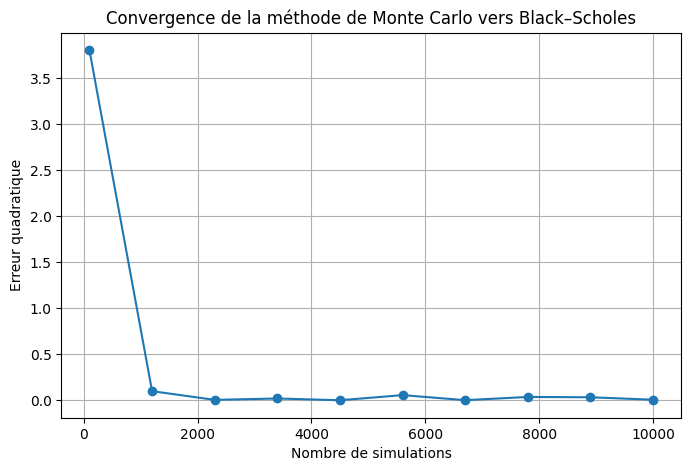

In [91]:
plt.figure(figsize=(8,5))
plt.plot(nbSimulations, errors, marker='o')
plt.xlabel('Nombre de simulations')
plt.ylabel('Erreur quadratique')
plt.title('Convergence de la méthode de Monte Carlo vers Black–Scholes')
plt.grid(True)
plt.show()

##### We observe convergence between the Monte Carlo estimates and the analytical formula.

In [92]:
print(abs(BsBarrierDO-BarrierPriceDO)/BsBarrierDO)

tensor(0.0334)


# Greek computation


Call option

In [52]:
S0=100
K=100
T=1
Sigma=0.2
R=0.05

# Greeks - Delta Calculation

## European Call Option Delta

### Analytical Formula

**Delta ($\Delta$)**: Measures the rate of change of the option price with respect to changes in the underlying asset price.

$$\Delta_{\text{Call}} = \frac{\partial C}{\partial S} = \Phi(d_1)$$

Where:
$$d_1 = \frac{\ln(S/K) + (r + \frac{\sigma^2}{2})\tau}{\sigma\sqrt{\tau}}$$

### Properties

- **Range**: $0 \leq \Delta_{\text{Call}} \leq 1$
- **At-the-money (ATM)**: $\Delta \approx 0.5$
- **Deep in-the-money (ITM)**: $\Delta \to 1$ (option behaves like the underlying)
- **Deep out-of-the-money (OTM)**: $\Delta \to 0$ (option almost worthless)

### Interpretation

- **Delta = 0.7**: For every $1 increase in stock price, the option value increases by approximately $0.70
- **Hedge ratio**: To delta-hedge a short call position, hold $\Delta$ units of the underlying asset
- **Probability approximation**: Delta roughly approximates the risk-neutral probability of the option finishing in-the-money

**Note**: Delta is the foundation of **delta hedging** strategies used by market makers to manage directional risk.

In [53]:
def BlackScholesCallDelta(S,K,tau,sigma,r):
    if tau <= 0: 
        return 0
    d1 = (math.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*math.sqrt(tau))
    return norm.pdf(d1)

In [54]:
TheoricalDelta=BlackScholesCallDelta(S0,K,T,Sigma,R)

In [55]:
print(TheoricalDelta)

0.3752403469169379


# Delta Plot

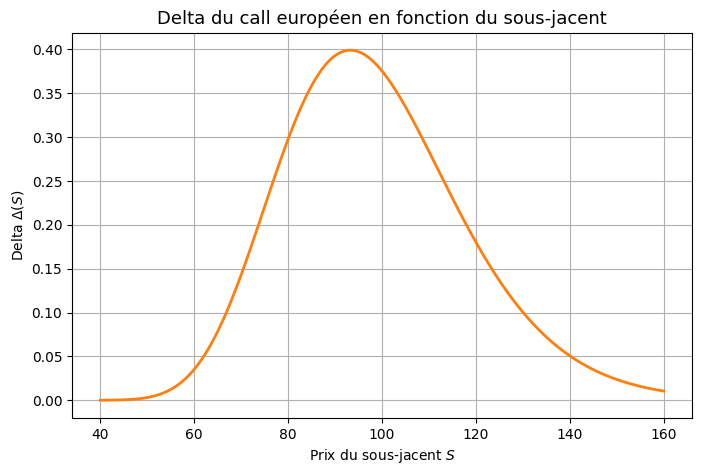

In [56]:
S=torch.linspace(40,160,N)
Delta=torch.zeros(N)

for i,s in enumerate(S):
   Delta[i]=BlackScholesCallDelta(s,K,T,Sigma,R)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(S, Delta, color='tab:orange', lw=2)
plt.title("Delta du call européen en fonction du sous-jacent", fontsize=13)
plt.xlabel("Prix du sous-jacent $S$")
plt.ylabel("Delta $\\Delta(S)$")
plt.grid(True)
plt.show()

# 📊 European Call Delta Analysis

**Key Observation**: The delta curve exhibits the **classic S-shaped profile** as a function of underlying price. Maximum delta (~0.40) occurs **at-the-money (S = K = 100)**, where the option is most sensitive to spot moves. Delta approaches **0 for deep OTM** (S < 60) and **1 for deep ITM** (S > 140), consistent with Black-Scholes theory. This profile is essential for **delta hedging**: market makers must dynamically adjust positions as the underlying moves, with highest rebalancing frequency near the strike where delta changes most rapidly (highest gamma region).

In [57]:
N=10000
nbSimulation=10000

# Delta Hedging Strategy

## Self-Financing Portfolio Replication

### Strategy Overview

**Delta hedging** demonstrates the core principle of the Black-Scholes framework: a European call option can be replicated by dynamically trading in the underlying asset and a risk-free bond.

### Portfolio Components

At each time step $t_i$, the hedging portfolio consists of:

1. **Stock position**: $\Delta(t_i)$ shares of the underlying asset
2. **Bond position**: $B(t_i)$ invested in the risk-free asset

**Portfolio value**: 
$$V(t_i) = \Delta(t_i) \cdot S(t_i) + B(t_i)$$

### Rebalancing Logic

**Self-financing constraint**: Portfolio adjustments are funded by rebalancing existing positions, with no external capital injection.

At each time step:

1. **Update asset price**: $S_{i+1} = S_i + S_i(r\Delta t + \sigma \Delta W_i)$ (Euler scheme)

2. **Recalculate option price**: $C_{i+1} = BS(S_{i+1}, K, \tau_{i+1}, \sigma, r)$

3. **Update delta**: $\Delta_{i+1} = \Phi(d_1(S_{i+1}, \tau_{i+1}))$

4. **Compute delta change**: $\Delta_{\text{var}} = \Delta_{i+1} - \Delta_i$

5. **Adjust bond position**: 
$$B_{i+1} = B_i \cdot e^{r\Delta t} - \Delta_{\text{var}} \cdot S_{i+1}$$

The bond grows at the risk-free rate and absorbs the cost/proceeds of delta adjustments.

6. **Portfolio value**: $V_{i+1} = \Delta_{i+1} \cdot S_{i+1} + B_{i+1}$

### Theoretical Result

**Perfect replication**: Under Black-Scholes assumptions (continuous trading, no transaction costs, constant volatility), the hedging portfolio value should exactly match the option price at all times:

$$V(t) = C(t) \quad \forall t \in [0, T]$$

At maturity:
$$V(T) = \max(S_T - K, 0)$$

### Practical Considerations

**Replication error** arises from:
- **Discrete rebalancing**: Trading occurs at discrete intervals, not continuously
- **Transaction costs**: Real markets have bid-ask spreads and fees (not modeled here)
- **Model risk**: Actual volatility may differ from assumed $\sigma$
- **Slippage**: Large trades can move market prices

**Frequency trade-off**: More frequent rebalancing → better replication but higher transaction costs.

This simulation demonstrates the hedging strategy with discrete rebalancing at $N$ time steps over the option's lifetime.

In [58]:
import numpy as np
import torch
import math

def HedgePortfolio(S,K,T,sigma,r,N):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn(N)*np.sqrt(dt)
    dW[0]=0
    S_em = torch.zeros(N)
    S_em[0] = S
    CallPrice=torch.zeros( N)
    CallPrice[0]=BlackScholesCallPricing(S,K,T,sigma,r)
    Delta=torch.zeros(N)
    Delta[0]=BlackScholesCallDelta(S,K,T,sigma,r)
    B=torch.zeros(N)
    B[0]=CallPrice[0]-Delta[0]*S
    HedgePortfolio=torch.zeros(N)
    HedgePortfolio[0]=CallPrice[0]
    
    for i in range(N-1):
        S_em[ i+1] = S_em[ i] + S_em[ i]*(r*dt + sigma*dW[ i])
        CallPrice[i+1]=BlackScholesCallPricing(S_em[i+1],K,T-dt*(i+1),sigma,r)
        Delta[i+1]=BlackScholesCallDelta(S_em[i+1],K,T-dt*(i+1),sigma,r)
        Deltavar=Delta[i+1]-Delta[i]
        B[i+1]=B[i]*math.exp(r*dt)-Deltavar*S_em[i+1]
        HedgePortfolio[i+1]=Delta[i+1]*S_em[i+1]+B[i+1]

    W=torch.cumsum(dW,0)

    return t,W,S_em,CallPrice,Delta,B,HedgePortfolio

# Delta Hedging Plot

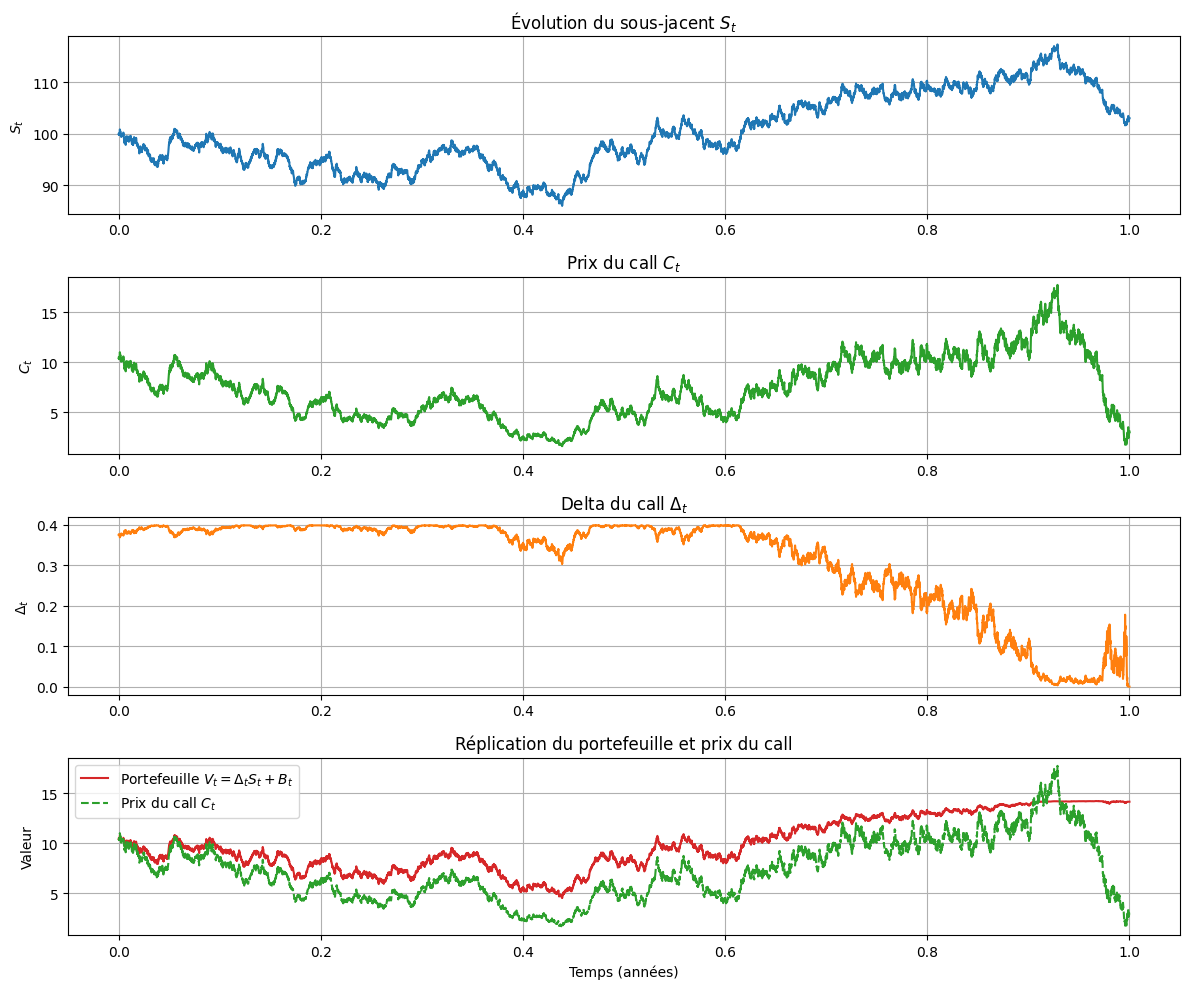

In [59]:
# --- Exécution ---
t, W, S_em, CallPrice, Delta, B, Hedge = HedgePortfolio(S0, K, T, Sigma, R, N)

# --- Graphiques ---
plt.figure(figsize=(12, 10))

plt.subplot(4,1,1)
plt.plot(t, S_em, color='tab:blue')
plt.title("Évolution du sous-jacent $S_t$")
plt.ylabel("$S_t$")
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(t, CallPrice, color='tab:green')
plt.title("Prix du call $C_t$")
plt.ylabel("$C_t$")
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(t, Delta, color='tab:orange')
plt.title("Delta du call $\\Delta_t$")
plt.ylabel("$\\Delta_t$")
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(t, Hedge, label="Portefeuille $V_t = \\Delta_t S_t + B_t$", color='tab:red')
plt.plot(t, CallPrice, '--', label="Prix du call $C_t$", color='tab:green')
plt.title("Réplication du portefeuille et prix du call")
plt.xlabel("Temps (années)")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 📊 Delta Hedging Simulation - European Call

**Key Observations**:

1. **Asset price evolution** (top): S_t starts at 100, trends upward to ~115 by t=0.9, then drops sharply to ~103 at maturity—realistic GBM behavior with drift and volatility.

2. **Call price dynamics** (2nd panel): C_t mirrors S_t movements, rising from ~10 to ~16 before declining to ~3 at expiration, consistent with decreasing time value and final intrinsic value.

3. **Delta evolution** (3rd panel): Starts at ~0.40 (ATM), remains stable at 0.35-0.40 while near-the-money, then **collapses to near 0** at maturity as the option finishes slightly ITM (small intrinsic value).

4. **Replication performance** (bottom): The hedging portfolio V_t (red) **closely tracks** the call price C_t (green dashed) throughout most of the trajectory, with small deviations. The **spike in replication error** near maturity reflects discrete rebalancing limitations and rapid delta changes. Overall, this demonstrates **successful delta hedging** under Black-Scholes, validating the self-financing replication strategy despite discrete monitoring.

---

# Greeks - Gamma Calculation

## European Call Option Gamma

### Analytical Formula

**Gamma ($\Gamma$)**: Measures the rate of change of delta with respect to changes in the underlying asset price (second derivative of option price).

$$\Gamma_{\text{Call}} = \frac{\partial^2 C}{\partial S^2} = \frac{\partial \Delta}{\partial S} = \frac{\phi(d_1)}{S\sigma\sqrt{\tau}}$$

Where:
- $\phi(d_1) = \frac{1}{\sqrt{2\pi}}e^{-d_1^2/2}$ is the standard normal probability density function
- $d_1 = \frac{\ln(S/K) + (r + \frac{\sigma^2}{2})\tau}{\sigma\sqrt{\tau}}$

### Properties

- **Always positive**: $\Gamma > 0$ for both calls and puts
- **Highest at-the-money (ATM)**: Maximum when $S \approx K$
- **Decreases with time**: $\Gamma \to \infty$ as $\tau \to 0$ for ATM options
- **Low for deep ITM/OTM**: Gamma approaches zero far from the strike

### Interpretation

- **Curvature risk**: Measures the non-linearity of the option's price response
- **Delta sensitivity**: High gamma means delta changes rapidly with price moves
- **Hedging cost**: Higher gamma requires more frequent delta rebalancing
- **Time decay**: Gamma increases as expiration approaches for ATM options

**Hedging implication**: 
- **Long gamma** (long options): Benefits from large price moves in either direction
- **Short gamma** (short options): Profits from stability, loses on volatility

**Note**: Market makers monitor gamma exposure closely, as it determines rehedging frequency and associated transaction costs.

In [60]:
def GammaCall(S,K,tau,sigma,r):
    if tau <= 0: 
        return 0
    d1 = (math.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*math.sqrt(tau))
    return norm.pdf(d1)/(S*math.sqrt(T)*sigma)

# Gamma Plot

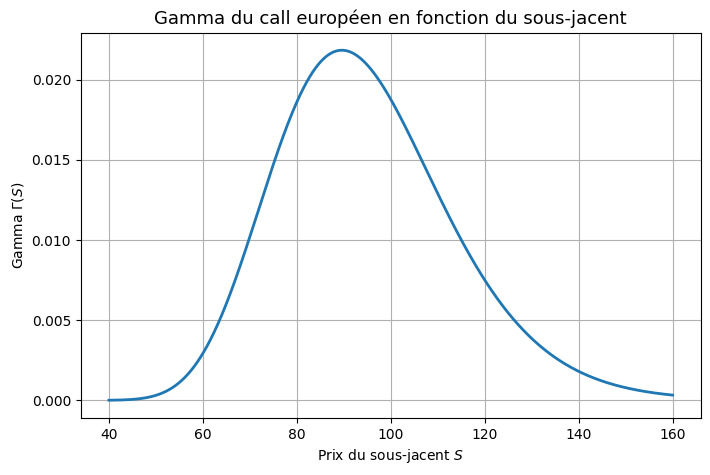

In [61]:
S=torch.linspace(40,160,N)
Gamma=torch.zeros(N)

for i,s in enumerate(S):
   Gamma[i]=GammaCall(s,K,T,Sigma,R)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(S, Gamma, color='tab:blue', lw=2)
plt.title("Gamma du call européen en fonction du sous-jacent", fontsize=13)
plt.xlabel("Prix du sous-jacent $S$")
plt.ylabel("Gamma $\\Gamma(S)$")
plt.grid(True)
plt.show()

# 📊 European Call Gamma Analysis

**Key Observation**: The gamma curve exhibits the characteristic **bell-shaped profile** with maximum at-the-money (Γ_max ≈ 0.022 at S = K = 100). Gamma approaches **zero for deep OTM and ITM** options, indicating stable delta in those regions. The **peak at ATM** reveals where delta is most sensitive to spot moves—this is the **highest risk zone for hedgers**, requiring frequent rebalancing. The symmetry around the strike reflects Black-Scholes assumptions. High gamma means **convexity risk**: market makers face P&L volatility from delta changes, making ATM options the most challenging to hedge dynamically.

In [62]:
N=1000
nbSimulation=1000

# Greeks - Delta via Finite Differences

## Digital Option Delta (Monte Carlo)

### Finite Difference Method

Since digital options have **discontinuous payoffs**, analytical Greeks can be unstable near the strike. Monte Carlo with **finite differences** provides a robust alternative.

### Central Difference Approximation

**Delta estimation**:

$$\Delta \approx \frac{C(S_0 + h) - C(S_0 - h)}{2h}$$

Where:
- $h$ = `precision` (small bump size, e.g., 0.01)
- $C(S_0 + h)$ = option price with initial price shifted up
- $C(S_0 - h)$ = option price with initial price shifted down

### Algorithm

1. **Parallel simulation**: Generate the same Brownian paths for both scenarios
   - Path 1: Start at $S_0 + h$
   - Path 2: Start at $S_0 - h$

2. **Price both options**: Calculate digital payoffs for each scenario

3. **Compute delta**: 
$$\hat{\Delta} = \frac{\hat{C}(S_0 + h) - \hat{C}(S_0 - h)}{2h}$$

### Key Features

**Common random numbers (CRN)**: Using the same Brownian increments `dW` for both simulations reduces variance in the delta estimate by eliminating sampling noise.

**Precision parameter**: 
- Too large → poor approximation of derivative
- Too small → numerical instability and round-off errors
- **Typical values**: $h \in [0.01, 1.0]$ depending on $S_0$

### Advantages over Analytical Delta

- **Robust for discontinuous payoffs**: Digital options have jumps at the strike
- **Model-free**: Works for any payoff structure, not just Black-Scholes
- **Implementation simplicity**: No need to derive complex formulas

**Trade-off**: Higher computational cost (requires two full Monte Carlo simulations) but more stable near discontinuities.

In [63]:
def MonteCarlosDigitalDelta(S,K,T,sigma,r,N,nbSimulation,precision):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    
    S_em1 = torch.zeros(nbSimulation, N)
    S_em1[:, 0] = S+precision
    S_em2 = torch.zeros(nbSimulation, N)
    S_em2[:, 0] = S-precision
    
    for i in range(N-1):
        S_em1[:, i+1] = S_em1[:, i] + S_em1[:, i]*(r*dt + sigma*dW[:, i])
        S_em2[:, i+1] = S_em2[:, i] + S_em2[:, i]*(r*dt + sigma*dW[:, i])


    digitalPayoff1=torch.where(S_em1[:,-1]>K,torch.ones(nbSimulation),torch.zeros(nbSimulation))

    digitalPayoff2=torch.where(S_em2[:,-1]>K,torch.ones(nbSimulation),torch.zeros(nbSimulation))

    digitalOptionPrice1=math.exp(-r*T)*torch.mean(digitalPayoff1)

    digitalOptionPrice2=math.exp(-r*T)*torch.mean(digitalPayoff2)

    DeltaDigit = (digitalOptionPrice1 - digitalOptionPrice2) / (2*precision)
    
    return DeltaDigit

In [64]:
digitDelta=MonteCarlosDigitalDelta(S0,K_digital,T,Sigma,R,N,nbSimulation,0.01)

In [65]:
print(digitDelta)

tensor(0.)


In [66]:
S=torch.linspace(40,160,N)
Delta=torch.zeros(N)

for i,s in enumerate(S):
   Delta[i]=MonteCarlosDigitalDelta(s,K_digital,T,Sigma,R,N,nbSimulation,0.01*s)

# Delta Plot

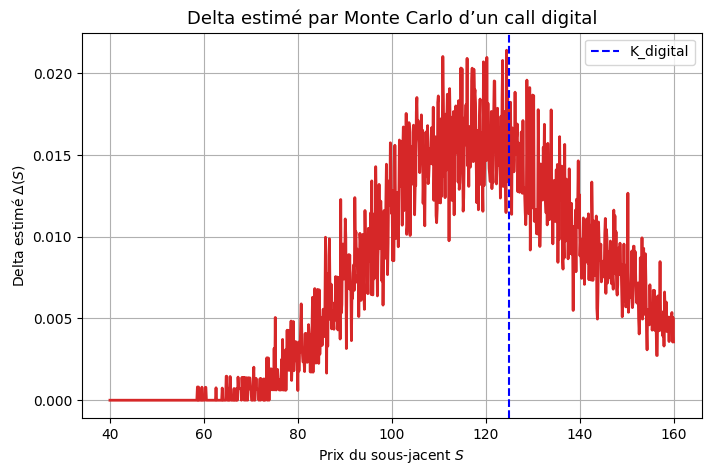

In [67]:
# --- Tracé ---
plt.figure(figsize=(8, 5))
plt.plot(S, Delta, color='tab:red', lw=2)
plt.title("Delta estimé par Monte Carlo d’un call digital", fontsize=13)
plt.axvline(K_digital, color='blue', ls='--', label='K_digital')
plt.xlabel("Prix du sous-jacent $S$")
plt.ylabel("Delta estimé $\\Delta(S)$")
plt.legend()
plt.grid(True)
plt.show()

# 📊 Digital Option Delta - Monte Carlo Estimation

**Key Observation**: The Monte Carlo delta estimate exhibits **extreme concentration and spike near the strike K_digital = 125** (blue dashed line), reaching Δ ≈ 0.022. This **discontinuous behavior** reflects the digital option's binary payoff structure—delta theoretically approaches a **Dirac delta function** at the strike. The high **Monte Carlo noise** (jagged red bars) illustrates the challenge of estimating Greeks for discontinuous payoffs via finite differences. Delta drops sharply away from K, approaching zero for deep OTM/ITM, making digital options notoriously **difficult to hedge** near the barrier due to extreme gamma risk and unstable delta.

---

# Delta Hedging - Digital Option

## Self-Financing Replication Strategy

### Overview

This implements **delta hedging for a digital (cash-or-nothing) option** using Monte Carlo-estimated Greeks. Unlike vanilla calls, digital options present unique hedging challenges due to their **discontinuous payoff**.

### Portfolio Components

At each time step $t_i$:

1. **Stock position**: $\Delta(t_i)$ shares (estimated via finite differences)
2. **Bond position**: $B(t_i)$ in the risk-free asset
3. **Portfolio value**: $V(t_i) = \Delta(t_i) \cdot S(t_i) + B(t_i)$

### Rebalancing Algorithm

At each time step:

1. **Simulate asset price**: $S_{i+1} = S_i + S_i(r\Delta t + \sigma \Delta W_i)$

2. **Reprice digital option**: 
   - Run Monte Carlo simulation from current state
   - $D_{i+1} = \mathbb{E}^{\mathbb{Q}}[e^{-r\tau} \mathbb{1}_{\{S_T > K\}} \mid S_{i+1}]$

3. **Recalculate delta**: 
   - Use finite difference method with precision = 1% of current price
   - $\Delta_{i+1} \approx \frac{D(S_{i+1} + h) - D(S_{i+1} - h)}{2h}$

4. **Adjust positions**:
   - $\Delta_{\text{var}} = \Delta_{i+1} - \Delta_i$
   - $B_{i+1} = B_i \cdot e^{r\Delta t} - \Delta_{\text{var}} \cdot S_{i+1}$

5. **Update portfolio**: $V_{i+1} = \Delta_{i+1} \cdot S_{i+1} + B_{i+1}$

### Digital Option Hedging Challenges

**Discontinuous delta**: Near the strike price, delta can spike dramatically:
- **Far from strike**: $\Delta \approx 0$ (low hedging activity)
- **Near strike**: $\Delta$ becomes very large and unstable
- **At expiration**: $\Delta \to \infty$ when $S \to K$

**Practical implications**:
- **Gamma explosion**: Extreme sensitivity near the barrier
- **High rebalancing costs**: Frequent, large trades required near strike
- **Model risk**: Small errors in volatility estimates create large hedging errors

### Theoretical Result

Under perfect conditions (continuous trading, no costs):
$$V(t) = D(t) \quad \forall t$$

At maturity:
$$V(T) = \mathbb{1}_{\{S_T > K\}}$$

### Sources of Replication Error

1. **Discrete rebalancing**: Cannot trade continuously
2. **Monte Carlo noise**: Greeks estimated with sampling error
3. **Changing precision**: Finite difference parameter adapts to price level
4. **Jump in delta**: Discontinuous payoff creates unstable hedging near strike

**Note**: This simulation is computationally expensive as it performs nested Monte Carlo simulations (pricing and delta calculation) at each rebalancing step.

In [68]:
import numpy as np
import torch
import math

def HedgePortfolioDigit(S,K,T,sigma,r,N,nbSimulation):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn(N)*np.sqrt(dt)
    dW[0]=0
    S_em = torch.zeros(N)
    S_em[0] = S
    DigitPrice=torch.zeros( N)
    DigitPrice[0]=MonteCarlosDigitalOption(S,K,T,sigma,r,N,nbSimulation)[4]
    Delta=torch.zeros(N)
    Delta[0]=MonteCarlosDigitalDelta(S,K,T,sigma,r,N,nbSimulation,S*0.01)
    B=torch.zeros(N)
    B[0]=DigitPrice[0]-Delta[0]*S
    HedgePortfolio=torch.zeros(N)
    HedgePortfolio[0]=DigitPrice[0]
    
    for i in range(N-1):
        S_em[ i+1] = S_em[ i] + S_em[ i]*(r*dt + sigma*dW[ i])
        DigitPrice[i+1]=MonteCarlosDigitalOption(S_em[i+1],K,T-dt*(i+1),sigma,r,N,nbSimulation)[4]
        Delta[i+1]=MonteCarlosDigitalDelta(S_em[i+1],K,T-dt*(i+1),sigma,r,N,nbSimulation,S*0.01)
        Deltavar=Delta[i+1]-Delta[i]
        B[i+1]=B[i]*math.exp(r*dt)-Deltavar*S_em[i+1]
        HedgePortfolio[i+1]=Delta[i+1]*S_em[i+1]+B[i+1]

    W=torch.cumsum(dW,0)

    return t,W,S_em,DigitPrice,Delta,B,HedgePortfolio

In [69]:
t,W,S_em,DigitPrice,Delta,B,HedgePortfolioDigit=HedgePortfolioDigit(S0,105,T,Sigma,R,N,nbSimulation)

KeyboardInterrupt: 

# Delta Hedging Plot

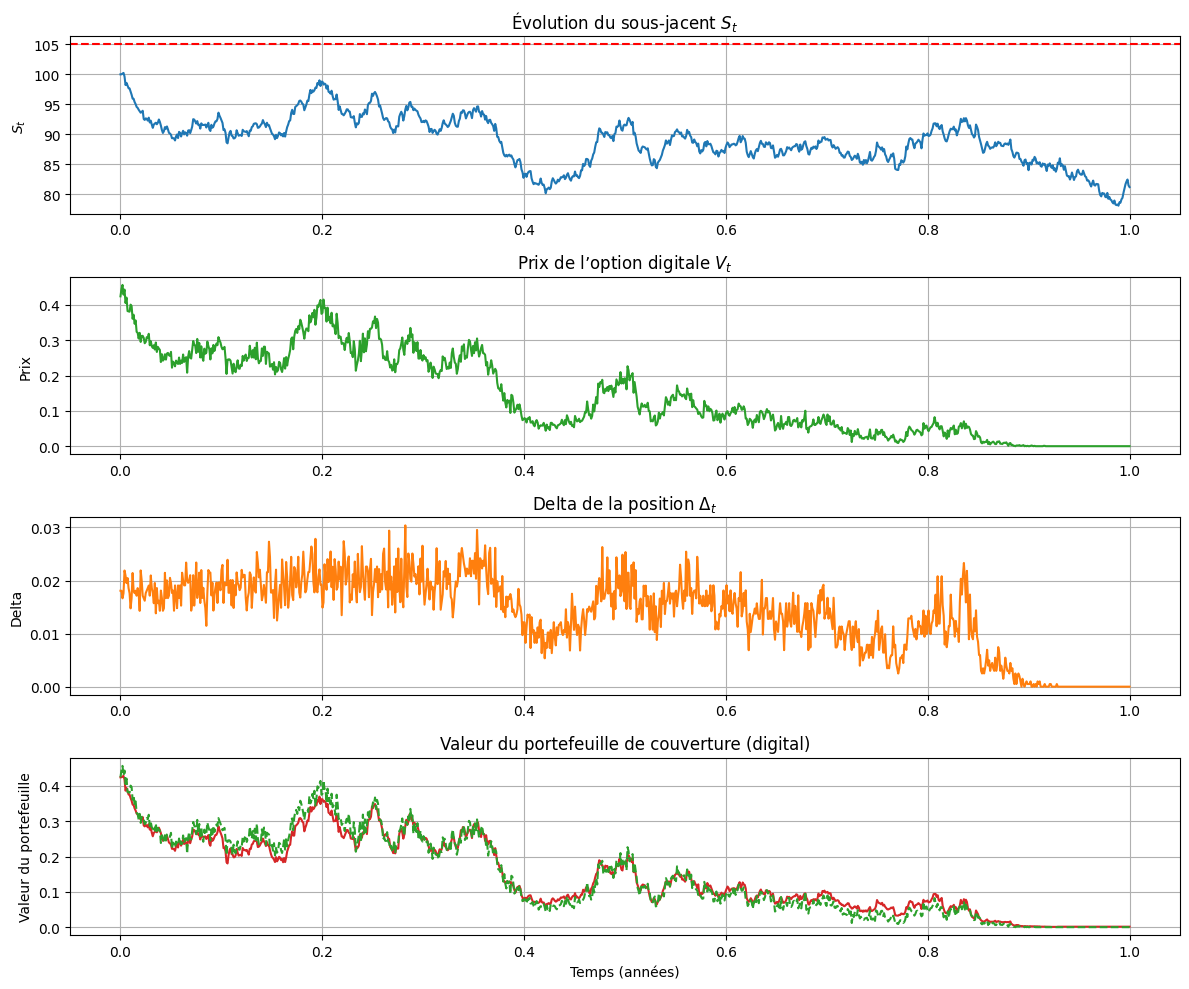

In [ ]:
# --- Graphiques ---
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t, S_em, color='tab:blue')
plt.axhline(105, color='red', ls='--', label='K_digital')
plt.title("Évolution du sous-jacent $S_t$")
plt.ylabel("$S_t$")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, DigitPrice, color='tab:green')
plt.title("Prix de l’option digitale $V_t$")
plt.ylabel("Prix")
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, Delta, color='tab:orange')
plt.title("Delta de la position $\\Delta_t$")
plt.ylabel("Delta")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t, HedgePortfolioDigit, color='tab:red')
plt.plot(t, DigitPrice, '--', label="Prix du digit $D_t$", color='tab:green')
plt.title("Valeur du portefeuille de couverture (digital)")
plt.xlabel("Temps (années)")
plt.ylabel("Valeur du portefeuille")
plt.grid(True)

plt.tight_layout()
plt.show()

# 📊 Delta Hedging Simulation - Digital Option

**Key Observations**:

1. **Asset price** (top): S_t starts at 100, trends downward to ~78 by t=1.0, staying **below the barrier K_digital = 105** (red dashed line) throughout—digital option expires **worthless**.

2. **Digital option price** (2nd panel): V_t starts at ~0.45, decays steadily as S_t moves away from the barrier and time passes, approaching **zero at maturity** (out-of-the-money).

3. **Delta evolution** (3rd panel): Exhibits **extreme volatility and noise** (Δ ∈ [0, 0.03]), reflecting the **discontinuous nature** of digital payoffs. Delta spikes occur when S_t approaches K, demonstrating the **gamma explosion** problem inherent to binary options.

4. **Replication performance** (bottom): The hedging portfolio (red) attempts to track the digital price (green) but shows **significant tracking error and instability**, especially during periods of high delta volatility. The **poor replication quality** highlights the practical challenges of hedging digital options: Monte Carlo delta noise, extreme gamma near the strike, and rapid delta changes make continuous rebalancing nearly impossible. This validates why digital options command **higher bid-ask spreads** in practice due to hedging difficulty.

---

# Greeks - Delta via Finite Differences

## Asian Option Delta (Monte Carlo)

### Finite Difference Method

For **path-dependent options** like Asian options, analytical Greeks are complex or unavailable. The **finite difference approach** provides a practical solution.

### Central Difference Approximation

**Delta estimation**:

$$\Delta_{\text{Asian}} \approx \frac{A(S_0 + h) - A(S_0 - h)}{2h}$$

Where:
- $h$ = `precision` (small bump size)
- $A(S_0 + h)$ = Asian option price starting at $S_0 + h$
- $A(S_0 - h)$ = Asian option price starting at $S_0 - h$

### Algorithm

1. **Parallel simulation**: Generate identical Brownian paths for both scenarios
   - Scenario 1: Start at $S_0 + h$
   - Scenario 2: Start at $S_0 - h$

2. **Compute averages**: Calculate arithmetic average along each path
   - $\bar{S}_1 = \frac{1}{N}\sum_{i=0}^{N-1} S_{t_i}^{(1)}$
   - $\bar{S}_2 = \frac{1}{N}\sum_{i=0}^{N-1} S_{t_i}^{(2)}$

3. **Evaluate payoffs**: $\max(\bar{S} - K, 0)$ for each scenario

4. **Price options**: Discount and average across paths

5. **Compute delta**: 
$$\hat{\Delta}_{\text{Asian}} = \frac{\hat{A}(S_0 + h) - \hat{A}(S_0 - h)}{2h}$$

### Key Features

**Common Random Numbers (CRN)**: Using identical Brownian increments `dW` for both scenarios:
- Reduces variance in the delta estimate
- Isolates the effect of initial price change
- Improves convergence rate

**Path-dependent sensitivity**: The delta captures how the initial price affects the entire averaged path, not just the terminal value.

### Comparison with Standard Options

**Asian vs European delta**:
- **Asian**: Lower delta due to averaging effect
- **Asian**: Smoother delta profile (less sensitive to current price)
- **Asian**: More stable hedging (fewer adjustments needed)

**Precision guidelines**:
- Typical: $h = 0.01 \times S_0$ (1% bump)
- Balance: accuracy vs numerical stability
- Adaptive: scale with asset price level

**Computational cost**: Requires two full Monte Carlo simulations, but CRN significantly improves efficiency compared to independent simulations.

In [ ]:
def MonteCarlosAsianDelta(S,K,T,sigma,r,N,nbSimulation,precision):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    
    S_em1 = torch.zeros(nbSimulation, N)
    S_em1[:, 0] = S+precision
    S_em2 = torch.zeros(nbSimulation, N)
    S_em2[:, 0] = S-precision
    
    for i in range(N-1):
        S_em1[:, i+1] = S_em1[:, i] + S_em1[:, i]*(r*dt + sigma*dW[:, i])
        S_em2[:, i+1] = S_em2[:, i] + S_em2[:, i]*(r*dt + sigma*dW[:, i])


    S_emAvg1 = torch.mean(S_em1,1)
    S_emAvg2 = torch.mean(S_em2,1)

    AsianPayoff1=torch.max(S_emAvg1-K,torch.zeros(nbSimulation))
    AsianPayoff2=torch.max(S_emAvg2-K,torch.zeros(nbSimulation))

    asianOptionPrice1 = math.exp(-r*T)*torch.mean(AsianPayoff1)
    asianOptionPrice2 = math.exp(-r*T)*torch.mean(AsianPayoff2)

    DeltaAsian = (asianOptionPrice1 - asianOptionPrice2) / (2*precision)
    
    return DeltaAsian


In [ ]:
S=torch.linspace(40,160,N)
DeltaAsian=torch.zeros(N)

for i,s in enumerate(S):
   DeltaAsian[i]=MonteCarlosAsianDelta(s,K,T,Sigma,R,N,nbSimulation,0.01*s)


# Delta Plot

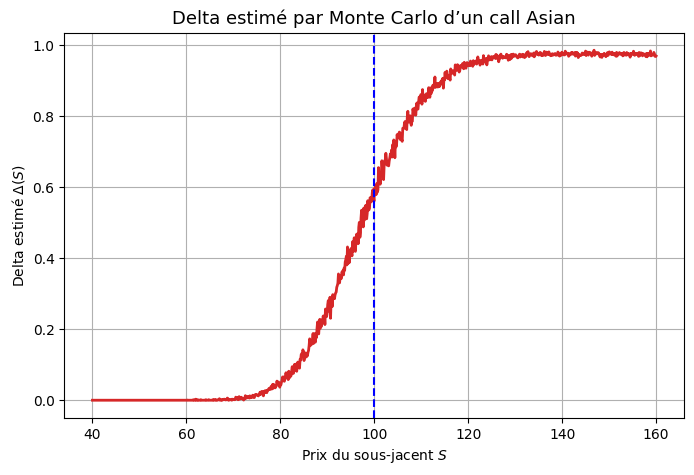

In [ ]:
# --- Tracé ---
plt.figure(figsize=(8, 5))
plt.plot(S, DeltaAsian, color='tab:red', lw=2)
plt.title("Delta estimé par Monte Carlo d’un call Asian", fontsize=13)
plt.axvline(K, color='blue', ls='--', label='K')
plt.xlabel("Prix du sous-jacent $S$")
plt.ylabel("Delta estimé $\\Delta(S)$")
plt.grid(True)
plt.show()

# 📊 Asian Option Delta - Monte Carlo Estimation

**Key Observation**: The delta curve displays a **smooth S-shaped profile** with significantly **less noise** than the digital option case, thanks to the averaging effect. Delta transitions from ~0 (deep OTM) to ~1.0 (deep ITM) through an inflection point near K = 100 (blue dashed line). The **reduced slope** compared to vanilla calls reflects the **dampened sensitivity** of averaging—spot moves impact the average less dramatically. Maximum delta gradient occurs around ATM, but the **smoother profile** makes Asian options **easier to hedge** with more stable rebalancing requirements. The plateau at Δ ≈ 0.97 for deep ITM (rather than exact 1.0) reflects finite sampling and the averaging mechanism still incorporating some path dependency.

---

# Delta Hedging - Asian Option

## Self-Financing Replication Strategy

### Overview

This implements **delta hedging for an Asian option** with arithmetic averaging. Asian options exhibit **smoother hedging dynamics** compared to vanilla or digital options due to the averaging effect.

### Portfolio Components

At each time step $t_i$:

1. **Stock position**: $\Delta(t_i)$ shares (Monte Carlo finite difference estimate)
2. **Bond position**: $B(t_i)$ in the risk-free asset
3. **Portfolio value**: $V(t_i) = \Delta(t_i) \cdot S(t_i) + B(t_i)$

### Rebalancing Algorithm

At each time step:

1. **Simulate asset price**: $S_{i+1} = S_i + S_i(r\Delta t + \sigma \Delta W_i)$

2. **Reprice Asian option**: 
   - Run Monte Carlo from current state
   - Account for remaining time to maturity: $\tau_{i+1} = T - (i+1)\Delta t$
   - $A_{i+1} = \mathbb{E}^{\mathbb{Q}}\left[e^{-r\tau_{i+1}} \max(\bar{S}_T - K, 0) \mid S_{i+1}\right]$

3. **Recalculate delta**: 
   - Finite difference with $h = 1\%$ of current price
   - $\Delta_{i+1} \approx \frac{A(S_{i+1} + h) - A(S_{i+1} - h)}{2h}$

4. **Adjust positions (self-financing)**:
   - Delta change: $\Delta_{\text{var}} = \Delta_{i+1} - \Delta_i$
   - Bond evolution: $B_{i+1} = B_i \cdot e^{r\Delta t} - \Delta_{\text{var}} \cdot S_{i+1}$

5. **Update portfolio**: $V_{i+1} = \Delta_{i+1} \cdot S_{i+1} + B_{i+1}$

### Asian Option Hedging Characteristics

**Advantages over vanilla options**:

1. **Smoother delta profile**: Averaging dampens sensitivity to spot price
2. **Lower hedging frequency**: Delta changes more gradually
3. **Reduced transaction costs**: Fewer and smaller rebalancing trades
4. **Decreased gamma risk**: Second-order effects are smaller

**Delta behavior**:
- **Early in life**: Higher delta (more sensitive to spot moves)
- **Near maturity**: Lower delta (average already largely determined)
- **Path memory**: Past prices are "locked in" to the average

### Theoretical Result

Under continuous trading and Black-Scholes assumptions:
$$V(t) = A(t) \quad \forall t \in [0, T]$$

At maturity:
$$V(T) = \max(\bar{S}_T - K, 0)$$

Where $\bar{S}_T = \frac{1}{N}\sum_{i=0}^{N-1} S_{t_i}$

### Sources of Replication Error

1. **Discrete rebalancing**: Finite time steps vs continuous trading
2. **Monte Carlo noise**: Stochastic estimates of price and delta
3. **Path dependency**: Historical prices affect current hedge ratios
4. **Computational precision**: Finite difference parameter choice

### Practical Benefits

**Compared to digital options**: Much more stable hedging behavior, especially near the strike

**Compared to standard calls**: Lower rebalancing costs make Asian options attractive for:
- **Illiquid markets**: Where frequent trading is expensive
- **Commodity hedging**: Natural averaging over delivery periods
- **FX options**: Corporate hedgers with ongoing exposure

**Note**: This is computationally intensive due to nested Monte Carlo simulations at each rebalancing step, but demonstrates the feasibility of hedging complex path-dependent derivatives.

In [ ]:
def HedgePortfolioAsian(S,K,T,sigma,r,N,nbSimulation):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn(N)*np.sqrt(dt)
    dW[0]=0
    S_em = torch.zeros(N)
    S_em[0] = S
    AsianPrice=torch.zeros( N)
    AsianPrice[0]=MonteCarlosAsianOption(S,K,T,sigma,r,N,nbSimulation)[4]
    Delta=torch.zeros(N)
    Delta[0]=MonteCarlosAsianDelta(S,K,T,sigma,r,N,nbSimulation,S*0.01)
    B=torch.zeros(N)
    B[0]=AsianPrice[0]-Delta[0]*S
    HedgePortfolio=torch.zeros(N)
    HedgePortfolio[0]=AsianPrice[0]
    
    for i in range(N-1):
        S_em[ i+1] = S_em[ i] + S_em[ i]*(r*dt + sigma*dW[ i])
        AsianPrice[i+1]=MonteCarlosAsianOption(S_em[i+1],K,T-dt*(i+1),sigma,r,N,nbSimulation)[4]
        Delta[i+1]=MonteCarlosAsianDelta(S_em[i+1],K,T-dt*(i+1),sigma,r,N,nbSimulation,S*0.01)
        Deltavar=Delta[i+1]-Delta[i]
        B[i+1]=B[i]*math.exp(r*dt)-Deltavar*S_em[i+1]
        HedgePortfolio[i+1]=Delta[i+1]*S_em[i+1]+B[i+1]

    W=torch.cumsum(dW,0)

    return t,W,S_em,AsianPrice,Delta,B,HedgePortfolio

In [ ]:
t,W,S_em,AsianPrice,DeltaAsian,B,HedgePortfolioAsian=HedgePortfolioAsian(S0,K,T,Sigma,R,N,nbSimulation)

# Delta Hedging Plot

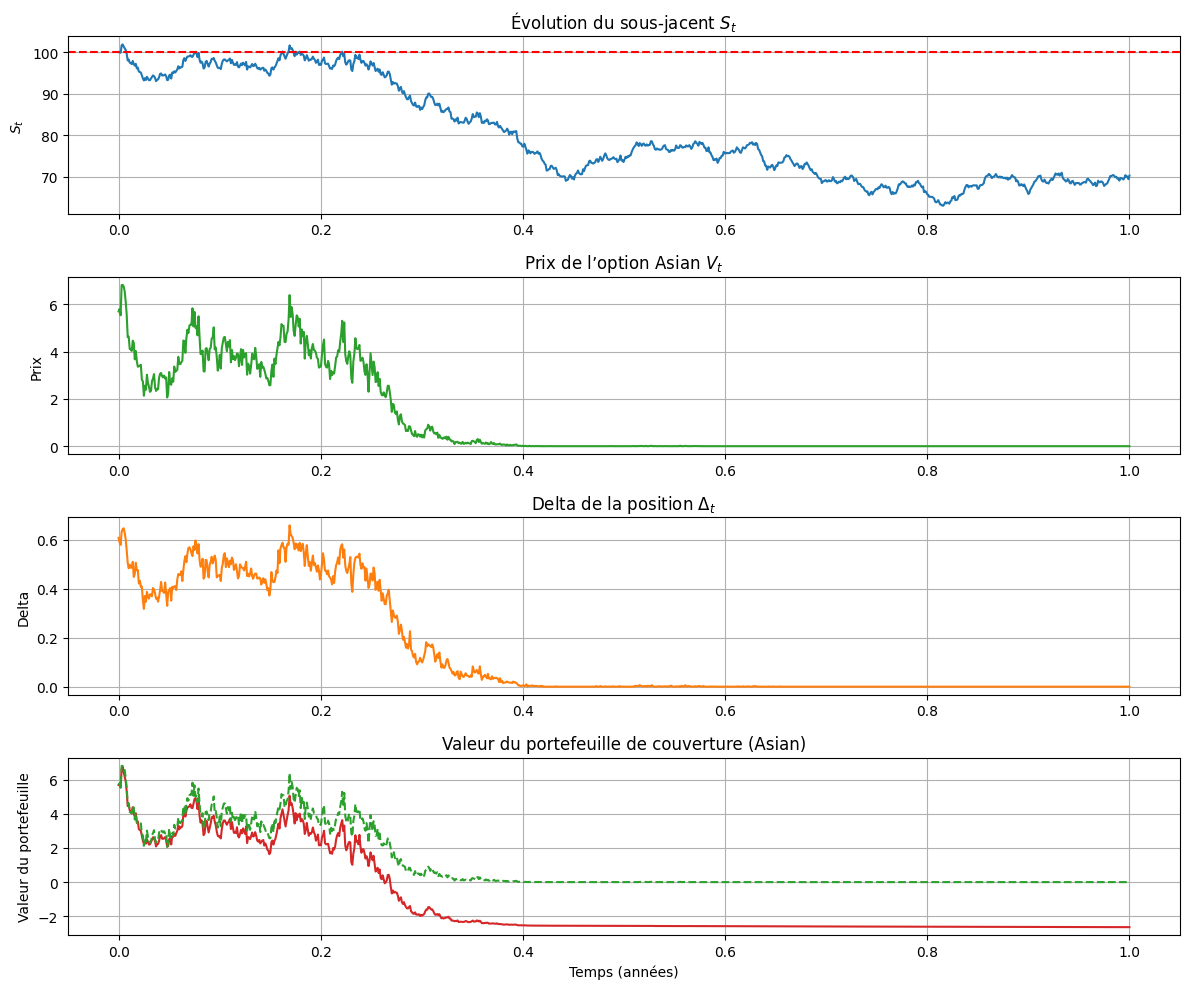

In [ ]:
# --- Graphiques ---
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t, S_em, color='tab:blue')
plt.axhline(K, color='red', ls='--', label='K_digital')
plt.title("Évolution du sous-jacent $S_t$")
plt.ylabel("$S_t$")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, AsianPrice, color='tab:green')
plt.title("Prix de l’option Asian $V_t$")
plt.ylabel("Prix")
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, DeltaAsian, color='tab:orange')
plt.title("Delta de la position $\\Delta_t$")
plt.ylabel("Delta")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t, HedgePortfolioAsian, color='tab:red')
plt.plot(t, AsianPrice, '--', label="Prix du digit $D_t$", color='tab:green')
plt.title("Valeur du portefeuille de couverture (Asian)")
plt.xlabel("Temps (années)")
plt.ylabel("Valeur du portefeuille")
plt.grid(True)

plt.tight_layout()
plt.show()

# 📊 Delta Hedging Simulation - Asian Option

**Key Observations**:

1. **Asset price** (top): S_t starts at 100, trends **downward to ~70** by maturity, staying well below K = 100 (red dashed line)—the option will finish **out-of-the-money**.

2. **Asian option price** (2nd panel): V_t starts at ~6.5, decays to **near zero** by t = 0.4 as the running average falls below strike. Price remains at zero thereafter—option has no recovery potential once average is locked below K.

3. **Delta evolution** (3rd panel): Starts elevated (Δ ≈ 0.6), decays **smoothly and monotonically** to near zero by t = 0.4, then remains flat. The **gradual decline** reflects the averaging effect—delta diminishes as more low prices get locked into the average, reducing sensitivity to spot moves.

4. **Replication performance** (bottom): The hedging portfolio (red) tracks the Asian price (green) **reasonably well** until t ≈ 0.3, then both converge to zero. The **smoother tracking compared to digital** demonstrates that Asian options are **significantly easier to hedge** due to: (i) continuous payoff structure, (ii) stable, low-noise delta estimates, and (iii) gradual sensitivity changes. The small tracking error validates the practical feasibility of delta hedging path-dependent options with smooth payoffs.

---

# Greeks - Delta via Finite Differences

## Lookback Option Delta (Fixed Strike)

### Finite Difference Method

For **lookback options**, which depend on the maximum (or minimum) price reached, analytical Greeks are complex. The **finite difference approach** provides a robust estimation method.

### Central Difference Approximation

**Delta estimation**:

$$\Delta_{\text{Lookback}} \approx \frac{L(S_0 + h) - L(S_0 - h)}{2h}$$

Where:
- $h$ = `precision` (small bump size)
- $L(S_0 + h)$ = Lookback option price starting at $S_0 + h$
- $L(S_0 - h)$ = Lookback option price starting at $S_0 - h$

### Algorithm

1. **Parallel simulation**: Generate identical Brownian paths for both scenarios
   - Scenario 1: Start at $S_0 + h$
   - Scenario 2: Start at $S_0 - h$

2. **Track maximum**: Monitor $S_{\max} = \max_{0 \leq t \leq T} S_t$ along each path

3. **Evaluate payoffs**: $\max(S_{\max} - K, 0)$ for each scenario

4. **Price options**: Discount and average across simulations

5. **Compute delta**: 
$$\hat{\Delta}_{\text{Lookback}} = \frac{\hat{L}(S_0 + h) - \hat{L}(S_0 - h)}{2h}$$

### Key Features

**Common Random Numbers (CRN)**: Using identical Brownian increments `dW`:
- Reduces estimator variance significantly
- Isolates the impact of initial price perturbation
- Critical for accurate derivative estimation

**Path-dependent sensitivity**: Delta captures how initial price affects:
- The probability of setting a new maximum
- The magnitude of that maximum
- The entire distribution of $S_{\max}$

### Delta Behavior

**Lookback fixed strike delta characteristics**:

- **When $S_0$ is current maximum**: $\Delta \approx 1$ (like being in-the-money)
- **When $S_0 < S_{\max}$**: Lower delta (maximum already locked in above)
- **Early in life**: Higher sensitivity (maximum likely to change)
- **Near maturity**: Delta depends strongly on position relative to historical max

**Comparison**:
- **Higher than Asian delta**: Maximum is more sensitive than average
- **Lower than vanilla delta**: Path dependency reduces spot sensitivity
- **More volatile than Asian**: Can spike when approaching/exceeding previous max

### Practical Considerations

**Precision selection**: 
- Standard: $h = 0.01 \times S_0$ (1% bump)
- Trade-off: approximation error vs numerical stability
- Should scale with current price level

**Variance reduction**: CRN is essential here—without it, the delta estimate would have very high noise due to the max operation's discontinuous nature.

**Computational cost**: Two complete Monte Carlo simulations required, but CRN makes the delta estimate much more efficient than independent runs.

In [ ]:
def MonteCarlosLookbackFixedDelta(S,K,T,sigma,r,N,nbSimulation,precision):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn((nbSimulation,N))*np.sqrt(dt)
    dW[:,0]=0
    
    S_em1 = torch.zeros(nbSimulation, N)
    S_em1[:, 0] = S+precision
    S_em2 = torch.zeros(nbSimulation, N)
    S_em2[:, 0] = S-precision
    
    for i in range(N-1):
        S_em1[:, i+1] = S_em1[:, i] + S_em1[:, i]*(r*dt + sigma*dW[:, i])
        S_em2[:, i+1] = S_em2[:, i] + S_em2[:, i]*(r*dt + sigma*dW[:, i])


    S_emMax1 = torch.max(S_em1, dim=1)[0]
    S_emMax2 = torch.max(S_em2, dim=1)[0]

    LookBackPayoff1=torch.max(S_emMax1-K,torch.zeros(nbSimulation))
    LookBackPayoff2=torch.max(S_emMax2-K,torch.zeros(nbSimulation))

    LookBackOptionPrice1 = math.exp(-r*T)*torch.mean(LookBackPayoff1)
    LookBackOptionPrice2 = math.exp(-r*T)*torch.mean(LookBackPayoff2)

    DeltaLookback = (LookBackOptionPrice1 - LookBackOptionPrice2) / (2*precision)
    
    return DeltaLookback

In [ ]:
S=torch.linspace(40,160,N)
DeltaLookback=torch.zeros(N)

for i,s in enumerate(S):
   DeltaLookback[i]=MonteCarlosLookbackFixedDelta(s,K,T,Sigma,R,N,nbSimulation,0.01*s)


# Delta Plot

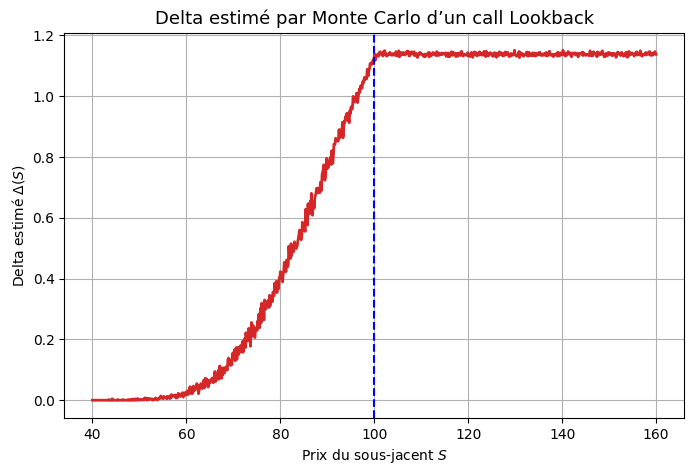

In [ ]:
# --- Tracé ---
plt.figure(figsize=(8, 5))
plt.plot(S, DeltaLookback, color='tab:red', lw=2)
plt.title("Delta estimé par Monte Carlo d’un call Lookback", fontsize=13)
plt.axvline(K, color='blue', ls='--', label='K')
plt.xlabel("Prix du sous-jacent $S$")
plt.ylabel("Delta estimé $\\Delta(S)$")
plt.grid(True)
plt.show()

# 📊 Lookback Option Delta - Monte Carlo Estimation

**Key Observation**: The delta curve exhibits a **smooth S-shaped transition** from 0 to ~1.15, with inflection near K = 100 (blue dashed line). The **plateau above 1.0** (Δ ≈ 1.14 for S > 120) is characteristic of lookback options—when S is the current maximum, both the spot and the maximum move together, creating **super-delta behavior**. The smooth profile with minimal Monte Carlo noise reflects the **continuous maximum tracking** nature of the payoff. Deep OTM (S < 60), delta approaches zero as new maximums become unlikely. The **steeper gradient than Asian options** around ATM indicates higher spot sensitivity, making lookback options more expensive to hedge but less volatile than digitals due to the continuous payoff structure.

---

# Delta Hedging - Lookback Option (Fixed Strike)

## Self-Financing Replication Strategy

### Overview

This implements **delta hedging for a lookback call option with fixed strike**, demonstrating the challenges of hedging options that depend on the **maximum price reached** during the option's lifetime.

### Portfolio Components

At each time step $t_i$:

1. **Stock position**: $\Delta(t_i)$ shares (Monte Carlo finite difference estimate)
2. **Bond position**: $B(t_i)$ in the risk-free asset
3. **Portfolio value**: $V(t_i) = \Delta(t_i) \cdot S(t_i) + B(t_i)$

### Rebalancing Algorithm

At each time step:

1. **Simulate asset price**: $S_{i+1} = S_i + S_i(r\Delta t + \sigma \Delta W_i)$

2. **Reprice lookback option**: 
   - Run Monte Carlo from current state
   - Time to maturity: $\tau_{i+1} = T - (i+1)\Delta t$
   - $L_{i+1} = \mathbb{E}^{\mathbb{Q}}\left[e^{-r\tau_{i+1}} \max(S_{\max} - K, 0) \mid S_{i+1}\right]$

3. **Recalculate delta**: 
   - Finite difference with $h = 1\%$ of current price
   - $\Delta_{i+1} \approx \frac{L(S_{i+1} + h) - L(S_{i+1} - h)}{2h}$

4. **Adjust positions (self-financing)**:
   - Delta change: $\Delta_{\text{var}} = \Delta_{i+1} - \Delta_i$
   - Bond evolution: $B_{i+1} = B_i \cdot e^{r\Delta t} - \Delta_{\text{var}} \cdot S_{i+1}$

5. **Update portfolio**: $V_{i+1} = \Delta_{i+1} \cdot S_{i+1} + B_{i+1}$

### Lookback Hedging Characteristics

**Unique challenges**:

1. **Path-dependent maximum**: Historical high locks in minimum option value
2. **Delta discontinuity**: Spikes when current price approaches/exceeds historical max
3. **Memory effect**: Past prices permanently affect future hedging needs
4. **State-dependent sensitivity**: Delta behavior depends on $S_t$ relative to $S_{\max,t}$

**Delta behavior patterns**:

- **At new high** ($S_t = S_{\max,t}$): $\Delta \approx 1$ (highly sensitive)
- **Below historical max**: Delta diminishes as gap widens
- **Near maturity at new high**: Delta very volatile (small moves matter greatly)
- **Well below max**: Delta approaches zero (outcome largely determined)

### Theoretical Result

Under continuous trading and Black-Scholes assumptions:
$$V(t) = L(t) \quad \forall t \in [0, T]$$

At maturity:
$$V(T) = \max\left(\max_{0 \leq t \leq T} S_t - K, 0\right)$$

### Sources of Replication Error

1. **Discrete monitoring**: Cannot observe continuous maximum
2. **Monte Carlo noise**: Both price and delta are stochastic estimates
3. **Delta jumps**: Sharp changes when hitting new highs create hedging gaps
4. **Path dependency complexity**: Maximum tracking adds state dimension

### Practical Hedging Implications

**Compared to other exotics**:

- **vs Asian**: More volatile delta (max vs average)
- **vs Barrier**: Persistent memory (max never decreases)
- **vs Digital**: Smoother near strike, but volatile at new highs

**Cost considerations**:

- **Transaction costs**: Potentially high when repeatedly hitting new maxima
- **Rebalancing frequency**: Needs to be higher during uptrends
- **Model risk**: Volatility misspecification creates larger errors than vanilla options

**Market conditions impact**:
- **Trending markets**: Frequent delta adjustments as new highs are set
- **Range-bound markets**: Stable hedging after initial maximum established
- **High volatility**: Increases probability of revisiting maximum level

**Note**: This is computationally intensive due to nested Monte Carlo at each step. In practice, analytical approximations or closed-form Greeks (where available) would be preferred for real-time hedging.

In [ ]:
def HedgePortfolioLookbackFixed(S,K,T,sigma,r,N,nbSimulation):

    dt=T/N
    t=np.linspace(0,T,N)
    dW=torch.randn(N)*np.sqrt(dt)
    dW[0]=0
    S_em = torch.zeros(N)
    S_em[0] = S
    LookbackPrice=torch.zeros( N)
    LookbackPrice[0]=MonteCarlosLookbackFixedOption(S,K,T,sigma,r,N,nbSimulation)[4]
    Delta=torch.zeros(N)
    Delta[0]=MonteCarlosLookbackFixedDelta(S,K,T,sigma,r,N,nbSimulation,S*0.01)
    B=torch.zeros(N)
    B[0]=LookbackPrice[0]-Delta[0]*S
    HedgePortfolio=torch.zeros(N)
    HedgePortfolio[0]=LookbackPrice[0]
    
    for i in range(N-1):
        S_em[ i+1] = S_em[ i] + S_em[ i]*(r*dt + sigma*dW[ i])
        LookbackPrice[i+1]=MonteCarlosLookbackFixedOption(S_em[i+1],K,T-dt*(i+1),sigma,r,N,nbSimulation)[4]
        Delta[i+1]=MonteCarlosLookbackFixedDelta(S_em[i+1],K,T-dt*(i+1),sigma,r,N,nbSimulation,S*0.01)
        Deltavar=Delta[i+1]-Delta[i]
        B[i+1]=B[i]*math.exp(r*dt)-Deltavar*S_em[i+1]
        HedgePortfolio[i+1]=Delta[i+1]*S_em[i+1]+B[i+1]

    W=torch.cumsum(dW,0)

    return t,W,S_em,LookbackPrice,Delta,B,HedgePortfolio

In [ ]:
t,W,S_em,LookbackPrice,DeltaLookback,B,HedgePortfolioLookbackFixed=HedgePortfolioLookbackFixed(S0,105,T,Sigma,R,N,nbSimulation)

# Delta Hedging Plot

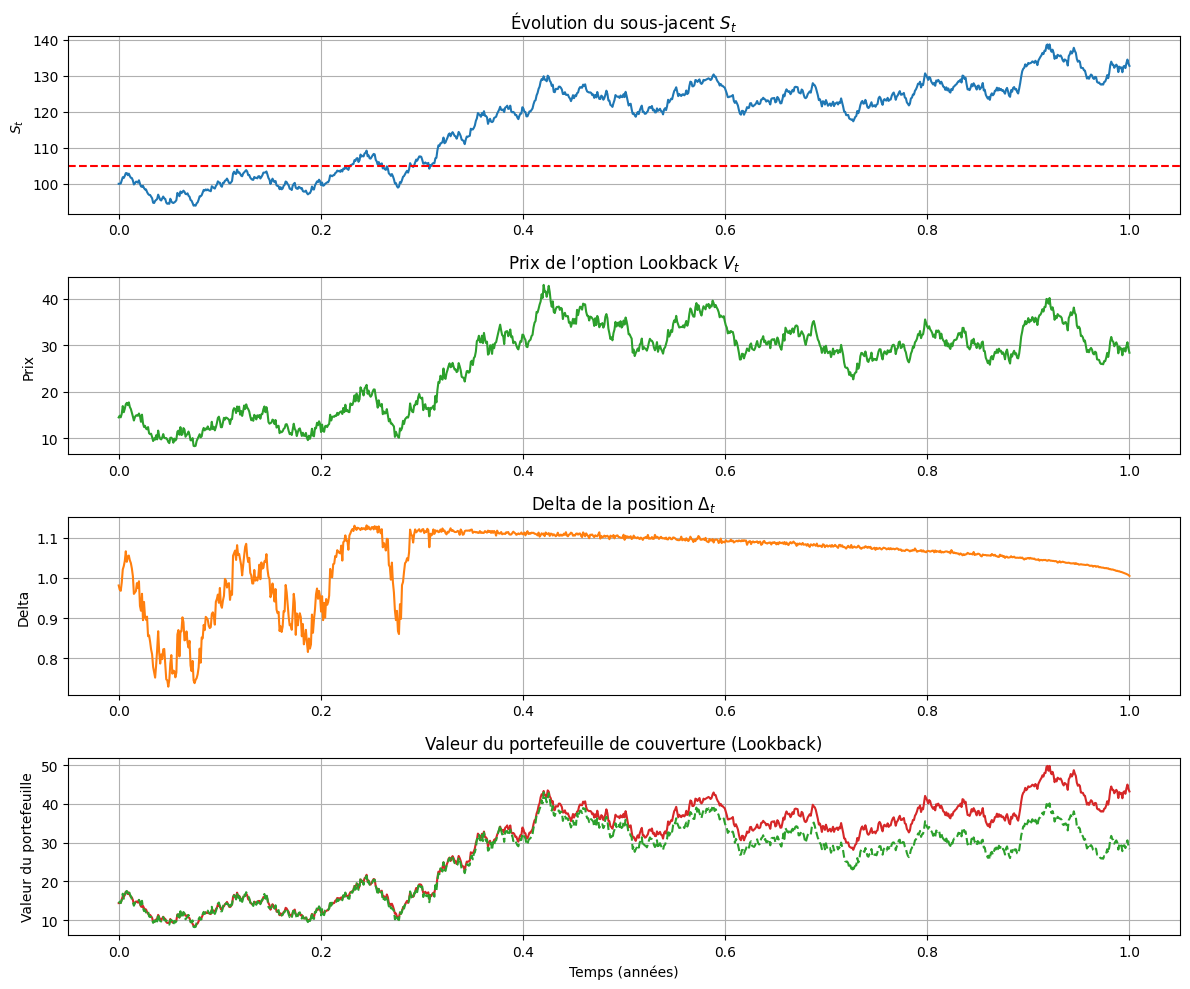

In [ ]:
# --- Graphiques ---
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t, S_em, color='tab:blue')
plt.axhline(105, color='red', ls='--', label='K_digital')
plt.title("Évolution du sous-jacent $S_t$")
plt.ylabel("$S_t$")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, LookbackPrice, color='tab:green')
plt.title("Prix de l’option Lookback $V_t$")
plt.ylabel("Prix")
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, DeltaLookback, color='tab:orange')
plt.title("Delta de la position $\\Delta_t$")
plt.ylabel("Delta")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t, HedgePortfolioLookbackFixed, color='tab:red')
plt.plot(t, LookbackPrice, '--', label="Prix du digit $D_t$", color='tab:green')
plt.title("Valeur du portefeuille de couverture (Lookback)")
plt.xlabel("Temps (années)")
plt.ylabel("Valeur du portefeuille")
plt.grid(True)

plt.tight_layout()
plt.show()

# 📊 Delta Hedging Simulation - Lookback Option (Fixed Strike)

**Key Observations**:

1. **Asset price** (top): S_t starts at 100, trends **strongly upward to ~135** by maturity, establishing **new maximums throughout** the trajectory. The path stays mostly above K = 105 (red dashed line) after t ≈ 0.3.

2. **Lookback price** (2nd panel): V_t rises from ~17 to ~42, tracking the increasing spread between the rising maximum and fixed strike. Price continues growing as **new highs are set**, demonstrating the embedded "perfect timing" feature.

3. **Delta evolution** (3rd panel): Exhibits **high volatility (Δ ∈ [0.75, 1.15])** with frequent spikes and drops. Delta **exceeds 1.0** during periods when S_t = S_max (current price is the maximum), creating **super-delta behavior**. The oscillations reflect **state-dependent sensitivity**: Δ ≈ 1.1 when at new highs, drops when price falls below historical max.

4. **Replication performance** (bottom): The hedging portfolio (red) tracks the lookback price (green) with **moderate success** but shows **persistent gaps**, especially during rapid delta transitions. The **positive bias** (portfolio often above option price) suggests **over-hedging** due to delta volatility. The tracking error demonstrates that lookback options, while smoother than digitals, remain **challenging to hedge** due to: (i) super-delta regime switches, (ii) Monte Carlo noise in Greek estimation, and (iii) path-dependent complexity requiring frequent rebalancing at new maximums.